Create Colab environment. (installs, imports, mounts, paths, etc)

In [ ]:
#@title torch install and device setup {form-width: "20%"}
### PyTorch
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset
## complete ##FIXIT change cuda:0 to gpu and ammend modelobj
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
## create toggle for pgbm gpu/cpu
device_in_use = str('gpu' if str(device) == 'cuda:0' else 'cpu')
print(device_in_use)

cpu
cpu


In [ ]:
#@title pip installs {form-width: "20%"}
#!pip install spotpy
if device_in_use == 'cpu':
  print('installing pgbm for cpu')
  !pip install pgbm

else:
  print('installing pgbm for gpu')
  !pip install pgbm
  !pip install Ninja

!pip install nonconformist
!pip install seaborn_qqplot

installing pgbm for cpu
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title import libraries {form-width: "20%"}

### import for dataframes and files
import numpy as np
import pandas as pd
import shelve

### general libraries
import time
from collections import defaultdict

### ML libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

### model libraries
# xgbm
import xgboost as xgbm
# pgbm
if device_in_use == 'cpu':
  import pgbm_nb as pgbm
else:
  import pgbm as pgbm
#lgbm
from nonconformist.cp import IcpRegressor
from nonconformist.cp import IcpClassifier
from nonconformist.nc import NcFactory
import lightgbm as lgbm

import matplotlib.pyplot as plt

### data visualisation and comparison libraries
import seaborn as sns
from sklearn.preprocessing import StandardScaler, normalize
#import spotpy
print('libraries imported')



libraries imported


In [ ]:
#@title mount drive
### mount MyDrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title set local drive path and device
### establish a path
path = '/content/drive/MyDrive/Aqua Regia/DES Model & Data/'
save_path = '/content/drive/MyDrive/Aqua Regia/PGBM thesis/models/'
print("operating from path:\t{}\ndevice in use:\t\t{}\nsave path:\t\t{}".format(path, device, save_path))

operating from path:	/content/drive/MyDrive/Aqua Regia/DES Model & Data/
device in use:		cpu
save path:		/content/drive/MyDrive/Aqua Regia/PGBM thesis/models/


In [ ]:
#@title DataFrame object { form-width: "20%" }
from sklearn.preprocessing import OneHotEncoder

class DataFrameObj(object):
  ''' Object to store DataFrames and methods for operating on the data.
  '''
  def __init__(self, _df ={}, paths = {}, features = [], classes = [], toggles = {'noise': None,
                                                                                  'ripple': None,
                                                                                  'lag': None,
                                                                                  'upstream': None
                                                                                  }):
    self.paths = paths
    self.features = features
    self.classes = classes
    self.toggles = toggles
    self.drop_df = pd.DataFrame()
    self._df = pd.DataFrame()
    self.open_shelf() 
    if len(_df.keys()):
      pass
    else:
      self.load_dfs()

### data loading and db loading methods
  def load_dfs(self):
    '''If paths are loaded then create a df from the paths.'''
    self.load_df(self.paths)

  def load_df(self, path):
    '''Append a constituent df into self._df from specified path'''
    for k, v in path.items():
      print("added dataframe for {}".format(k))
      try:
        df =  pd.read_csv(v, sep=",", infer_datetime_format=True, index_col = 0)
        df.index = pd.to_datetime(df.index)
        multi_cols = pd.MultiIndex.from_product([[k], df.columns], names = ['constituent', 'element'])
        df.columns = multi_cols
        self._df = pd.concat([self._df, df], axis=1)
      except Exception as e:
        print(e)
    pass

  def one_hot(self):
    ohe = OneHotEncoder(categories='auto',  
    drop=None, 
    sparse=True, 
    dtype= 'float64', 
    handle_unknown='error')
    pass

  def open_shelf(self):
    ''' load shelve database object'''
    with shelve.open(path + 'upstream_networks') as db:
      self.upstream_networks = db['upstream_networks']

### data manipulation methods
  def add_noise(self, constit, elem, date, mu = 0, sigma=0.1):
    ''' add noise with mean mu and deiation sigma.
    '''
    upstream_noise = self.upstream_df.loc[date,:].copy()
    for col in upstream_noise.columns:
      noise = upstream_noise[col].normal(mu, sigma, [len(upstream_noise), len(upstream_noise)])
      upstream_noise[col + '_noise'] = upstream_noise[col] + noise
    return upstream_noise , self._df.loc[upstream_noise.index,('{}_data'.format(constit), elem)]

  def add_ripple(self, constit, elem, date, _len = 14):
    ''' add_ripple by shifting and adding by step _len.
    Inputs
    Parameters
    Output
    '''
    upstream_rip = self.upstream_df.loc[date,:].copy()
    for col in upstream_rip.columns:
      df = pd.DataFrame()
      for i in range(1,_len,1):
        series = self._df['flow_data'][col].shift(periods = i, fill_value=0.0)
        series.name = self._df['flow_data'][col].name+'_LC{}'.format(i)
        df[series.name] = series
      upstream_rip = pd.concat([upstream_rip, df], axis=1)
    self.toggles['ripple'] = _len  
    return upstream_rip.iloc[14:,:], self._df.loc[upstream_rip.index, '{}_data'.format(constit)][elem].iloc[14:]

  def add_lag(self, lag_type):
    ''' Lag.
    '''    
    X ='X'
    y = 'y'
    print('lag methods introduced in Milestone 3')
    self.toggles['lag'] = lag_type
    return self._df['upstream'], self._df['{}_data'.format(self.constituent)][self.element].values

  def add_ewm(self, constit, elem, date):
    upstream_ewm = self.upstream_df.loc[date,:].copy()
    for col in upstream_ewm.columns:
      upstream_ewm[col + '_ewm'] = upstream_ewm[col].ewm(span=5.0).mean()
    return upstream_ewm , self._df.loc[upstream_ewm.index,('{}_data'.format(constit), elem)]

  def get_X_y(self, *args, **kwargs): #(constit, elem, method, date)
    print('X_y')#, kwargs)
    if self.toggles['upstream']:
      if kwargs['method'] == 'ewm':
        print('adding ewm')
        X, y = self.add_ewm(kwargs['constit'], kwargs['elem'], kwargs['date'])
        print(y.name, type(y))
      elif kwargs['method'] == 'rip':
        print('adding ripples')
        X, y = self.add_ripple(kwargs['constit'], kwargs['elem'], kwargs['date'])
        print(y.name, type(y))
      elif kwargs['method'] == 'van':
        print('using vanilla')
        X = self.upstream_df.loc[kwargs['date'],:].copy()
        y = self._df.loc[X.index, ('{}_data'.format(kwargs['constit']), kwargs['elem'])] 
        print(y.name, type(y))
      pass
    else:
      #X = self.upstream_df.loc[kwargs['date'],:].copy()
      #y = self._df.loc[X.index, ('{}_data'.format(kwargs['constit']), kwargs['elem'])]
      pass
    return X, y

  def get_train_test(self, split, shuffle, seed, strat=None, *args, **kwargs):
    print('tr_te')#, kwargs)
    X, y = self.get_X_y(**kwargs)
    return train_test_split(X, y,
                            test_size=split,
                            shuffle = shuffle,
                            random_state = seed,
                            stratify = strat) 

  def train_test_val(self, val_split, val_shuffle, val_seed, split, shuffle, seed, strat=None, *args, **kwargs):
    print('tr_te_val')#, kwargs)
    X_tr, X_te, y_tr, y_te = self.get_train_test(split, shuffle, seed, strat=None, **kwargs)
    return ((X_tr, X_te, y_tr, y_te ), (train_test_split(X_tr, y_tr,
                            test_size = val_split,
                            shuffle = val_shuffle,
                            random_state = val_seed,
                            stratify = strat)))

  def add_upstream(self, element, _first = False):
    ''' get persistent db data
    '''
    ### get dataframe of upstream links, catchments and nodes
    upstream = self.upstream_networks[element]
    ### exclude catchment areas and zero data    
    if len(upstream.columns):
      nodes_links = [series['name'] for series in upstream['properties'].values if series['feature_type'] != 'catchment' and self._df['flow_data'][series['name']].sum() > 0]
    else:
      nodes_links = []
      if self._df['flow_data'][element].sum() > 0:
        nodes_links.append(element)
    ### add element at end or begining default is at the end
    if _first:
      nodes_links.insert(0, element)
      pass
    else:
      nodes_links.append(element)
      pass
    #print('upstream added: {}'.format(element))
    self.toggles['upstream'] = True
    self.upstream_df =  self._df['flow_data'][nodes_links]
    return self._df['flow_data'][nodes_links]


In [ ]:
#@title Model object {form-width: "20%"}
class ModelObj(object):
  def __init__(self, X_tr, X_te, y_tr, y_te, X_tr_val=None, X_val=None, y_tr_val=None, y_val=None, *args, **kwargs):
    self.args = args
    self.kwargs = kwargs
    self.X_tr = X_tr
    self.y_tr = y_tr
    self.X_te = X_te
    self.y_te = y_te
    self.X_tr_val = X_tr_val
    self.y_tr_val = y_tr_val
    self.X_val = X_val
    self.y_val = y_val
    
    ##FIXIT device_in_use not device. check for errors.
    if device_in_use == 'cpu':
      print('Using cpu')
      pass
    else:
      print('Using gpu')
      pass
    pass 

  def save_model(self, name):
    '''
    Inputs:
      name ~ name of model
      path ~ the path loaded into program ##FIXIT MOdelObj.path_save
    Parameters:
      ModelObj.model ~ PGBM() model
      PGBM().save(path + name)
    Output:
      saved file with name in path .'''
    self.model.save(save_path + name+'.pt')
    pass
    
  def objective(self, yhat, y, sample_weight=None):
    '''
    Inputs
    Parameters
    Output.'''
    gradient = (yhat - y)
    if device_in_use == 'cpu':
      hessian = np.ones_like(yhat)  
    else:
      hessian = torch.ones_like(yhat)      
    return gradient, hessian

  def rmseloss_metric(self, yhat, y, sample_weight=None):
    '''
    Inputs
    Parameters
    Output.'''
    if device_in_use == 'cpu':
      loss = np.sqrt(np.mean(np.square(yhat - y)))
    else:
      loss = (yhat - y).pow(2).mean().sqrt()
    return loss
  
  def pgbm_model(self):
    '''create PGBM model due to [citation].
    '''
    self.params = {'min_split_gain':0,
      'min_data_in_leaf':2,
      'max_leaves':8,
      'max_bin':64,
      'learning_rate':0.1,
      'n_estimators':100,
      'verbose':1,
      'early_stopping_rounds':100,
      'feature_fraction':1,
      'bagging_fraction':1,
      'seed':1,
      'reg_lambda':1,
      'split_parallel':'feature',
      'distribution':'normal'}
    if not len(self.args) and not len(self.kwargs):
      #00
      print('creating model with default params')
      t0 = time.time()
      if device_in_use == 'cpu':        
        self.model = pgbm.PGBMRegressor().fit(self.X_tr, self.y_tr) ##FIXIT arguments from function
      else:
        self.model = pgbm.PGBMRegressor(device=device).fit(self.X_tr, self.y_tr) ##FIXIT arguments from function
      t1 = time.time()
      print('pgbm model created. time taken: {}'.format(t1-t0))
      pass
    else:
      print("creating model with custom params")
      n_forecasts = 1000
      base_estimators = 2000
      self.params['n_estimators'] = base_estimators

    # Build datasets
      train_data = (self.X_tr, self.y_tr)
      train_val_data = (self.X_tr_val, self.y_tr_val)
      valid_data = (self.X_val, self.y_val)
      t0 =time.time()
      self.model = pgbm.PGBM()      
      self.model.train(train_val_data, objective=self.objective, metric=self.rmseloss_metric, valid_set=valid_data, params=self.params)
      t1 = time.time()
      # Find best tree correlation & distribution on validation set
      best_distribution, best_tree_correlation = self.model.optimize_distribution(self.X_val, self.y_val)
      t2 = time.time()
      # Set iterations to best iteration from validation set
      self.params['n_estimators'] = self.model.best_iteration
      self.model.distribution = 'normal'

      # everytime optimised dist is run, it updates base_case_tree_correlation (see line 761)
      # want as low as possible
      base_case_tree_correlation = self.model.tree_correlation
      yhat_dist_pgbm = self.model.predict_dist(self.X_te, n_forecasts=n_forecasts)
      # Scoring
      self.crps_old = np.mean(self.model.crps_ensemble(yhat_dist_pgbm, self.y_te))
      # Optimal case
      self.model.distribution = best_distribution
      self.model.tree_correlation = best_tree_correlation
      yhat_dist_pgbm = self.model.predict_dist(self.X_te, n_forecasts=n_forecasts)
      # Scoring
      self.crps_new = np.mean(self.model.crps_ensemble(yhat_dist_pgbm, self.y_te))  
      # Print scores
      print(f"Base case CRPS {self.crps_old:.2f}, distribution = normal, tree_correlation = {base_case_tree_correlation}")
      print(f"Optimal CRPS {self.crps_new:.2f}, distribution = {self.model.distribution}, tree_correlation = {self.model.tree_correlation}")
      print('time taken (pgbm): {}'.format(t1-t0))
    return (t0,t1,t2)

  def lgbm_model(self):
    self.params = {}
    t0 = time.time()
    lgbm_model = lgbm.LGBMRegressor()


    # Default nonconformity measure
    nc = NcFactory.create_nc(lgbm_model)
    # Inductive conformal regressor
    self.model = IcpRegressor(nc)
    # Fit the ICP using the proper training set
    self.model.fit(self.X_tr_val, self.y_tr_val)
    # Calibrate the ICP using the calibration set
    self.model.calibrate(self.X_val, self.y_val)
    t1 = time.time()
    self.gbm_model = lgbm.LGBMRegressor()
    self.gbm_model.fit(self.X_tr_val, self.y_tr_val)
    t2 = time.time()
    print('time taken (lgbm): {}'.format(t1-t0))
    return (t0,t1,t2)

  def xgbm_model(self):
    self.params = {}
    t0 = time.time()
    xgbm_model = xgbm.XGBRegressor()

    # Default nonconformity measure
    nc = NcFactory.create_nc(xgbm_model)
    # Inductive conformal regressor
    self.model = IcpRegressor(nc)
    # Fit the ICP using the proper training set
    self.model.fit(self.X_tr_val, self.y_tr_val)
    # Calibrate the ICP using the calibration set
    self.model.calibrate(self.X_val, self.y_val)
    t1 = time.time()
    self.gbm_model = xgbm.XGBRegressor()
    self.gbm_model.fit(self.X_tr_val, self.y_tr_val)
    t2 = time.time()
    print('time taken (xgbm): {}'.format(t1-t0))
    return (t0,t1,t2)



In [ ]:

def PICP(y_test, lower_b, upper_b):
  return ((y_test <= upper_b) & (y_test >= lower_b)).mean()

def MPI(lower_b, upper_b):
  return (upper_b-lower_b).mean()

def NMPI(MPI, R):
  return MPI/R

def CLC(MPI, R, nu, mu, y_test, lower_b, upper_b):
  NMPI = MPI/R
  return NMPI*(1+np.exp(-nu*(PICP(y_test, lower_b, upper_b)-mu)))

def CWC():
  pass

def FBI():
  '''Fred Bennett's Indicator'''
  pass

In [ ]:
#@title Load DataFrameObj with data{ form-width: "20%" }

constituents_= ['pn','pp','sed']
constituents = ['din','don','dop','frp','pn', 'pp','sed']

### create DataFrame Object and load flow_data.csv
obj = DataFrameObj(paths = {'flow_data': path+'flow_data.csv'}) 
### load constituent data    
for constit in constituents :
  ### load the DataFrameObject with constituent data
  obj.load_df({'{}_data'.format(constit): path+constit+'_data.csv'})
up = obj.add_upstream(obj._df.columns[0][1])
print('samples: ',len(obj._df))
print('from: ',obj._df.index[0], ' to: ', obj._df.index[-1])
print('elements: ', len(obj._df['flow_data'].columns))

added dataframe for flow_data
added dataframe for din_data
added dataframe for don_data
added dataframe for dop_data
added dataframe for frp_data
added dataframe for pn_data
added dataframe for pp_data
added dataframe for sed_data
samples:  11688
from:  1986-07-01 00:00:00  to:  2018-06-30 00:00:00
elements:  93


(992, 1)


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


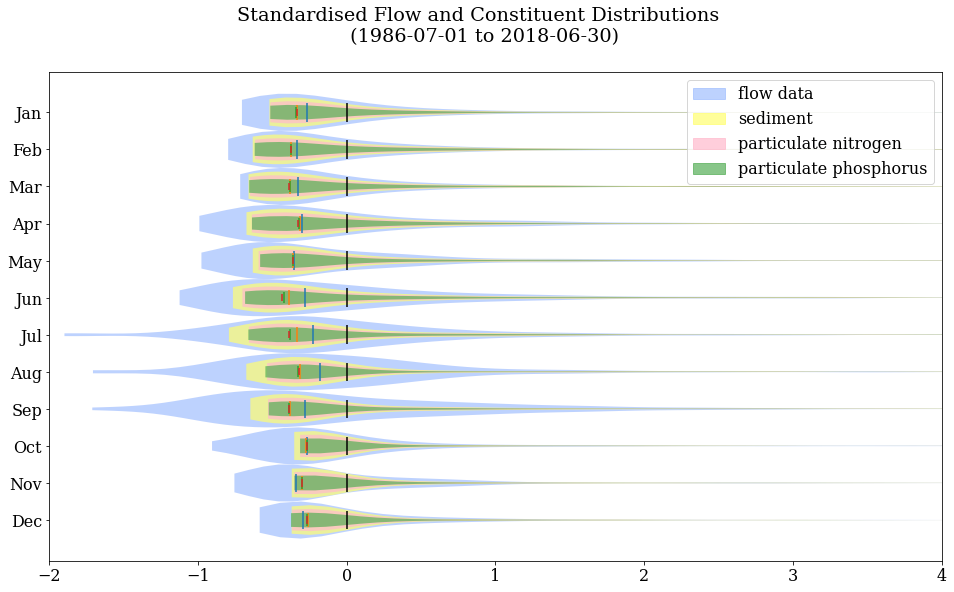

In [ ]:
plt.rcParams["figure.figsize"] = (16,9)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['font.size'] = 16
import matplotlib.patches as mpatches
scaler = StandardScaler()

plt.suptitle('Standardised Flow and Constituent Distributions \n ({} to {})'.format(str(obj._df.index[0])[:10], str(obj._df.index[-1])[:10]))

flow_data = [scaler.fit_transform(np.array(obj._df[obj._df.index.month  == mon][('flow_data', 'link for catchment SC #119')]).reshape(-1,1)) for mon in range(1,13,1)]
sed_data = [scaler.fit_transform(np.array(obj._df[obj._df.index.month  == mon][('sed_data', 'link for catchment SC #119')]).reshape(-1,1)) for mon in range(1,13,1)]
pp_data = [scaler.fit_transform(np.array(obj._df[obj._df.index.month  == mon][('pp_data', 'link for catchment SC #119')]).reshape(-1,1)) for mon in range(1,13,1)]
pn_data = [scaler.fit_transform(np.array(obj._df[obj._df.index.month  == mon][('pn_data', 'link for catchment SC #119')]).reshape(-1,1)) for mon in range(1,13,1)]
print(flow_data[0].shape)

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
colours = ['#a2bffe', '#fffe71','#ffbacd','#56ae57']
widths = [0,0.2,0.4,0.6]
alphas = [.7,.7,.7,.7]
labels = []
v1 = plt.violinplot(flow_data[::-1],
               range(1,13,1),
               points=100,
               widths = 1-widths[0],
               vert=False,
               showmeans=True,
               showextrema=False,
               showmedians=True,
               bw_method='scott')
for patch in v1['bodies']:
        patch.set(facecolor=colours[0], alpha = alphas[0])
labels.append((mpatches.Patch(color=v1['bodies'][0].get_facecolor().flatten()), 'flow data'))
v2 = plt.violinplot(sed_data[::-1],
               range(1,13,1),
               points=100,
               widths =1-widths[1],
               vert=False,
               showmeans=False,
               showextrema=False,
               showmedians=True,
               bw_method='scott')
for patch in v2['bodies']:
        patch.set(facecolor=colours[1], alpha = alphas[1])
labels.append((mpatches.Patch(color=v2['bodies'][0].get_facecolor().flatten()), 'sediment'))
v3 = plt.violinplot(pp_data[::-1],
               range(1,13,1),
               points=100,
               widths =1-widths[2],
               vert=False,
               showmeans=False,
               showextrema=False,
               showmedians=True,
               bw_method='scott')
for patch in v3['bodies']:
        patch.set(facecolor=colours[2], alpha = alphas[2])
labels.append((mpatches.Patch(color=v3['bodies'][0].get_facecolor().flatten()), 'particulate nitrogen'))
v4 = plt.violinplot(pn_data[::-1],
               range(1,13,1),
               points=100,
               widths =1-widths[3],
               vert=False,
               showmeans=False,
               showextrema=False,
               showmedians=True,
               bw_method='scott')
for patch in v4['bodies']:
        patch.set(facecolor=colours[3], alpha = alphas[3])
labels.append((mpatches.Patch(color=v4['bodies'][0].get_facecolor().flatten()), 'particulate phosphorus'))

v1['cmeans'].set_color('k')



plt.yticks(range(1,13,1), labels=months[::-1])
plt.xlim(left = -2, right=4)
plt.legend(*zip(*labels), loc='upper right')
plt.show()

In [ ]:
start_date = '{}-{}-{}'.format(obj._df.index[0].year, obj._df.index[0].month, obj._df.index[0].day)
end_date = '{}-{}-{}'.format(obj._df.index[-1].year, obj._df.index[-1].month, obj._df.index[-1].day)
dates = pd.date_range(start=start_date, end=end_date)
dates1 = obj._df.index[obj._df.index.month >= 7]
dates2 = obj._df.index[obj._df.index.month < 7]

args = {'constit': 'sed',
        'elem': obj._df.columns[0][1],
        'method': 'ewm',
        'date': dates}

In [ ]:
all_models = {}
data_sets = ['van','ewm','rip']
models_sets = ['xgbm', 'lgbm', 'pgbm']


def run_models(constit):
  
  models_dict = {}
  args['constit'] = constit
  times = {}

  data_dict = {}
  for d in data_sets:
    args['method'] = d
    data_dict[d] = obj.train_test_val(.1,None,0,.2,None,0,None,**args)

  for d_s in data_sets:
    models_dict[d_s] = {}
    for m_s in models_sets:
      t0 = time.time()
      models_dict[d_s][m_s] = ModelObj(data_dict[d_s][0][0].to_numpy(),
                                     data_dict[d_s][0][1].to_numpy(),
                                     data_dict[d_s][0][2].to_numpy(),
                                     data_dict[d_s][0][3].to_numpy(),
                                     data_dict[d_s][1][0].to_numpy(),
                                     data_dict[d_s][1][1].to_numpy(),
                                     data_dict[d_s][1][2].to_numpy(),
                                     data_dict[d_s][1][3].to_numpy(),
                                     name='{}_{}'.format(m_s,d_s))
      if m_s == 'xgbm':
        ts = models_dict[d_s][m_s].xgbm_model()
      elif m_s == 'lgbm':
        ts = models_dict[d_s][m_s].lgbm_model()
      else:
        ts = models_dict[d_s][m_s].pgbm_model()
      t1 = time.time()
      times['{}_{}_{}'.format(constit, d_s, m_s)] = (t1-t0, ts)
  all_models[constit] = models_dict
  return times


In [ ]:
all_times = {}
for constit in constituents:
  t = run_models(constit)
  all_times[constit] = t


tr_te_val
tr_te
X_y
using vanilla
('din_data', 'link for catchment SC #119') <class 'pandas.core.series.Series'>
tr_te_val
tr_te
X_y
adding ewm
('din_data', 'link for catchment SC #119') <class 'pandas.core.series.Series'>
tr_te_val
tr_te
X_y
adding ripples
link for catchment SC #119 <class 'pandas.core.series.Series'>
Using cpu
[12:52:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:52:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
time taken (xgbm): 12.742934226989746
Using cpu
time taken (lgbm): 2.2346034049987793
Using cpu
creating model with custom params
Base case CRPS 181.54, distribution = normal, tree_correlation = 0.05
Optimal CRPS 177.61, distribution = gumbel, tree_correlation = 0.05
time taken (pgbm): 75.99291205406189
Using cpu
[12:54:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in 

In [ ]:
print(all_times['pn']['pn_van_pgbm'][1][0])
for constit in constituents_:
  for d_s in data_sets:
    for m_s in models_sets:
      print(all_times[constit]['{}_{}_{}'.format(constit,d_s,m_s)])

1668863644.1034262
(7.571547985076904, (1668863633.6773918, 1668863637.4527552, 1668863641.2480295))
(2.8549766540527344, (1668863641.2484672, 1668863642.6785605, 1668863644.1030288))
(18.68674111366272, (1668863644.1034262, 1668863655.3966918, 1668863662.0641928))
(14.922603368759155, (1668863662.7908623, 1668863670.2243526, 1668863677.7124035))
(5.865626573562622, (1668863677.7127347, 1668863680.6491604, 1668863683.578027))
(38.474079847335815, (1668863683.5784104, 1668863710.3439865, 1668863721.223348))
(104.52002048492432, (1668863722.0534322, 1668863774.5196671, 1668863826.5721412))
(52.38519287109375, (1668863826.5725477, 1668863852.6761873, 1668863878.9560096))
(583.564035654068, (1668863878.958957, 1668864418.8676891, 1668864460.8394475))
(8.57009744644165, (1668864479.3125076, 1668864483.1827435, 1668864487.880879))
(3.553976535797119, (1668864487.8831992, 1668864489.9508448, 1668864491.4361594))
(14.33370566368103, (1668864491.436587, 1668864498.722913, 1668864505.0561163))
(

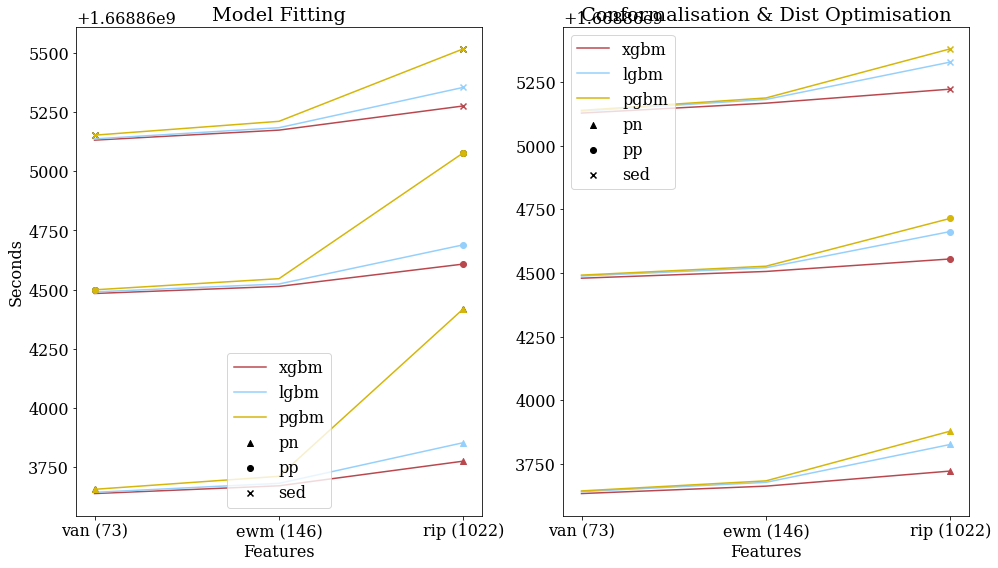

In [ ]:
fig, ax = plt.subplots(1,2)
#fig.suptitle("Training time and PI time", fontsize=16)
#fig.autofmt_xdate(rotation=45)
labels = ['']
lines = [':','--','-.']
alphas = [1,.8,.6]
markers = ['^','o','x']
colors = {'lgbm': 'xkcd:Light Blue', 'pgbm': 'xkcd:Dark Yellow', 'xgbm': 'xkcd:Dusty Red'}

for constit in constituents_:
  for m_s in models_sets:
    #for idx, d_s in enumerate(data_sets):
      ax[0].plot([10,20,30],
                [all_times[constit]['{}_{}_{}'.format(constit,d_s,m_s)][1][1] for d_s in data_sets],
                color=colors[m_s],label = m_s)
      
      ax[1].plot([10, 20, 30],
                [all_times[constit]['{}_{}_{}'.format(constit,d_s,m_s)][1][0] for d_s in data_sets],
                color=colors[m_s],label = m_s)
ax[0].set_title('Model Fitting')      
ax[0].set_xticks([10,20,30])
ax[0].set_xticklabels(['van (73)', 'ewm (146)', 'rip (1022)'])
ax[0].set_xlabel('Features')
ax[0].set_ylabel('Seconds')
ax[1].set_title('Conformalisation & Dist Optimisation')  
ax[1].set_xticks([10,20,30])
ax[1].set_xticklabels(['van (73)', 'ewm (146)', 'rip (1022)'])
ax[1].set_xlabel('Features')

for idx, constit in enumerate(constituents_):
  ax[0].scatter([30],
             [all_times[constit]['{}_{}_{}'.format(constit,'rip','pgbm')][1][1]],
             marker = markers[idx],
             color = 'k',
             zorder = 1,
             label = constit)
  ax[0].scatter([10],
             [all_times[constit]['{}_{}_{}'.format(constit,'van','pgbm')][1][1]],
             marker = markers[idx],
             color = 'k',
             zorder = 1,
             label = constit)
  ax[0].scatter([30],
             [all_times[constit]['{}_{}_{}'.format(constit,'rip','xgbm')][1][1]],
             marker = markers[idx],
             color = colors['xgbm'],
             label = constit)
  ax[0].scatter([30],
             [all_times[constit]['{}_{}_{}'.format(constit,'rip','lgbm')][1][1]],
             marker = markers[idx],
             color = colors['lgbm'],
             label = constit)
  ax[1].scatter([30],
             [all_times[constit]['{}_{}_{}'.format(constit,'rip','pgbm')][1][0]],
             marker = markers[idx],
             color = colors['pgbm'])
  ax[1].scatter([30],
             [all_times[constit]['{}_{}_{}'.format(constit,'rip','xgbm')][1][0]],
             marker = markers[idx],
             color = colors['xgbm'],
             label = constit)
  ax[1].scatter([30],
             [all_times[constit]['{}_{}_{}'.format(constit,'rip','lgbm')][1][0]],
             marker = markers[idx],
             color = colors['lgbm'],
             label = constit)
  ax[0].scatter([30],
             [all_times[constit]['{}_{}_{}'.format(constit,'rip','pgbm')][1][1]],
             marker = markers[idx],
             color = colors['pgbm'],
             zorder = 1000,
             label = constit)
  ax[0].scatter([10],
             [all_times[constit]['{}_{}_{}'.format(constit,'van','pgbm')][1][1]],
             marker = markers[idx],
             color = colors['pgbm'],
             zorder = 1000,
             label = constit)
h, l = ax[0].get_legend_handles_labels()
ax[0].legend([h[0],h[1],h[2], h[9],h[15],h[21]], [l[0], l[1],l[2], l[9], l[15],l[21]])
ax[1].legend([h[0],h[1],h[2], h[9],h[15],h[21]], [l[0], l[1],l[2], l[9], l[15],l[21]])

plt.show()


In [ ]:
eval_dict = {}
nu =.9
mu=.1
for constit in constituents:
  eval_dict[constit] = {}
  for d_s in data_sets:
    eval_dict[constit][d_s] = {}
    for m_s in models_sets:
      eval_dict[constit][d_s][m_s] = {}
      if m_s == 'pgbm':
        pred = all_models[constit][d_s][m_s].model.predict(all_models[constit][d_s][m_s].X_te)
        eval_dict[constit][d_s][m_s]['r2_score'] = r2_score(all_models[constit][d_s][m_s].y_te, pred)
        pred_dist = all_models[constit][d_s][m_s].model.predict_dist(all_models[constit][d_s][m_s].X_te, n_forecasts=1000)
        eval_dict[constit][d_s][m_s]['PICP'] = PICP(all_models[constit][d_s][m_s].y_te, pred_dist.min(axis=0), pred_dist.max(axis=0))
        eval_dict[constit][d_s][m_s]['MPI'] = MPI(pred_dist.min(axis=0), pred_dist.max(axis=0))
        eval_dict[constit][d_s][m_s]['NMPI'] = NMPI(MPI(pred_dist.min(axis=0), pred_dist.max(axis=0)), pred_dist.max(axis=0)- pred_dist.min(axis=0) )
        eval_dict[constit][d_s][m_s]['pred'] = pred
        eval_dict[constit][d_s][m_s]['pred_dist'] = pred_dist
        eval_dict[constit][d_s][m_s]['CLC'] = CLC(MPI(pred_dist.min(axis=0),
                                                      pred_dist.max(axis=0)),
                                                  pred_dist.max(axis=0)- pred_dist.min(axis=0),
                                                  nu, 
                                                  mu,
                                                  all_models[constit][d_s][m_s].y_te,
                                                  pred_dist.min(axis=0),
                                                  pred_dist.max(axis=0))
      else:
        pred = all_models[constit][d_s][m_s].model.predict(all_models[constit][d_s][m_s].X_te, significance = (1-0.9) )
        pred_ = all_models[constit][d_s][m_s].gbm_model.predict(all_models[constit][d_s][m_s].X_te)
        eval_dict[constit][d_s][m_s]['r2_score'] = r2_score(all_models[constit][d_s][m_s].y_te,
                                                            pred_)
        eval_dict[constit][d_s][m_s]['PICP'] = PICP(all_models[constit][d_s][m_s].y_te, pred[:,0], pred[:,1])
        eval_dict[constit][d_s][m_s]['MPI'] = MPI(pred[:,0], pred[:,1])
        eval_dict[constit][d_s][m_s]['NMPI'] = NMPI(MPI(pred[:,0], pred[:,1]), pred[:,1]-pred[:,0])
        eval_dict[constit][d_s][m_s]['pred'] = pred_
        eval_dict[constit][d_s][m_s]['pred_dist'] = pred
        eval_dict[constit][d_s][m_s]['CLC'] = CLC(MPI(pred[:,0], pred[:,1]),
                                                  pred[:,1]-pred[:,0],
                                                  nu, mu,
                                                  all_models[constit][d_s][m_s].y_te,
                                                  pred[:,0],
                                                  pred[:,1])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
print(eval_dict['pn']['van']['pgbm'].keys())

dict_keys(['r2_score', 'PICP', 'MPI', 'NMPI', 'pred', 'pred_dist', 'CLC'])


In [ ]:
df = pd.DataFrame()
for constit in ['sed']:
  for d_s in ['ewm']:
    for m_s in models_sets:
      if m_s == 'pgbm':
        dict_ = {'pred': eval_dict[constit][d_s][m_s]['pred'],
                 'target': all_models[constit][d_s][m_s].y_te,
                 'lower': eval_dict[constit][d_s][m_s]['pred_dist'].min(axis=0),
                 'upper': eval_dict[constit][d_s][m_s]['pred_dist'].max(axis=0),
                 'model': pd.Series([m_s for i in range(len(all_models[constit][d_s][m_s].y_te))]),
                 'data_set': [d_s for i in range(len(all_models[constit][d_s][m_s].y_te))]}
        _df = pd.DataFrame(dict_)
        df = pd.concat([df, _df], ignore_index =True)
      else:
        dict_ = {'pred': eval_dict[constit][d_s][m_s]['pred'],
                 'target': all_models[constit][d_s][m_s].y_te,
                 'lower': eval_dict[constit][d_s][m_s]['pred_dist'][:,0],
                 'upper': eval_dict[constit][d_s][m_s]['pred_dist'][:,1],
                 'model': pd.Series([m_s for i in range(len(all_models[constit][d_s][m_s].y_te))]),
                 'data_set': [d_s for i in range(len(all_models[constit][d_s][m_s].y_te))]}
        _df = pd.DataFrame(dict_)
        df = pd.concat([df, _df], ignore_index =True)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7014 entries, 0 to 7013
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pred      7014 non-null   float64
 1   target    7014 non-null   float64
 2   lower     7014 non-null   float64
 3   upper     7014 non-null   float64
 4   model     7014 non-null   object 
 5   data_set  7014 non-null   object 
dtypes: float64(4), object(2)
memory usage: 328.9+ KB
None


Text(0.5, 1.08, 'Pairwise constituent comparison \n KDE plot on diagonal,  Regression plot above, QQ plot below \n constit = "sed", data_set = "ewm"')

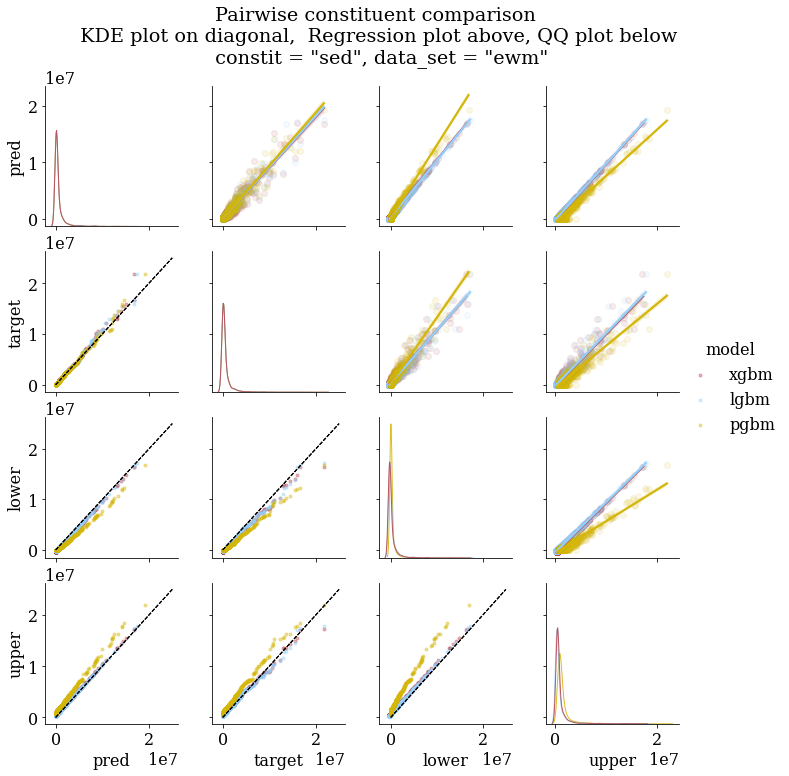

In [ ]:
print(df.info())
from seaborn_qqplot import pplot
from scipy import stats
plt.rcParams["figure.figsize"] = (16,9)

def qqplot(x, y, **kwargs):
    _, xr = stats.probplot(x, fit=False)
    _, yr = stats.probplot(y, fit=False)
    xpoints = ypoints = plt.ylim()
    lims = [
            np.min([0, 0]),  # min of both axes
            np.max([25000000, 25000000]),  # max of both axes
]
    plt.plot(lims, lims, linestyle='--', color='k', lw=1, scalex=True, scaley=True)
    plt.scatter(xr, yr, **kwargs)

g = sns.PairGrid(df[['pred', 'target','lower','upper','model']], hue='model', palette={'lgbm': 'xkcd:Light Blue',
                                                                                       'pgbm': 'xkcd:Dark Yellow',
                                                                                       'xgbm': 'xkcd:Dusty Red'})
g.map_upper(sns.regplot, fit_reg=True, ci = 90, scatter_kws = {'alpha': .1})
g.map_lower(qqplot, marker='.', alpha=.4)
g.map_diag(sns.kdeplot, lw=1, alpha=.9, legend=False)
g.add_legend(loc="center right",fontsize=16, bbox_transform=plt.gcf().transFigure)
g.fig.suptitle('Pairwise constituent comparison \n KDE plot on diagonal,  Regression plot above, QQ plot below \n constit = "sed", data_set = "ewm"', y=1.08)


In [ ]:

flow_data = scaler.fit_transform(np.array(obj._df[('flow_data', 'link for catchment SC #119')]).reshape(-1,1)).flatten()
sed_data = scaler.fit_transform(np.array(obj._df[('sed_data', 'link for catchment SC #119')]).reshape(-1,1)).flatten()
pp_data = scaler.fit_transform(np.array(obj._df[('pp_data', 'link for catchment SC #119')]).reshape(-1,1)).flatten()
pn_data = scaler.fit_transform(np.array(obj._df[('pn_data', 'link for catchment SC #119')]).reshape(-1,1)).flatten()



In [ ]:

df = pd.DataFrame([pd.Series(flow_data, name = 'flow'),
                   pd.Series(sed_data, name = 'sed'),
                   pd.Series(pp_data, name = 'pp'),
                   pd.Series(pn_data, name = 'pn')]).T

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11688 entries, 0 to 11687
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   flow    11688 non-null  float64
 1   sed     11688 non-null  float64
 2   pp      11688 non-null  float64
 3   pn      11688 non-null  float64
dtypes: float64(4)
memory usage: 365.4 KB
None


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:156: UserWarning: The handle <matplotlib.patches.Patch object at 0x7fc8777a1490> has a label of '_nolegend_' which cannot be automatically added to the legend.
  figlegend = self._figure.legend(handles, labels, **kwargs)


Text(0.5, 1.08, 'Pairwise constituent scaled comparison \n KDE plots on diagonal, Regression plots above, QQ plots below')

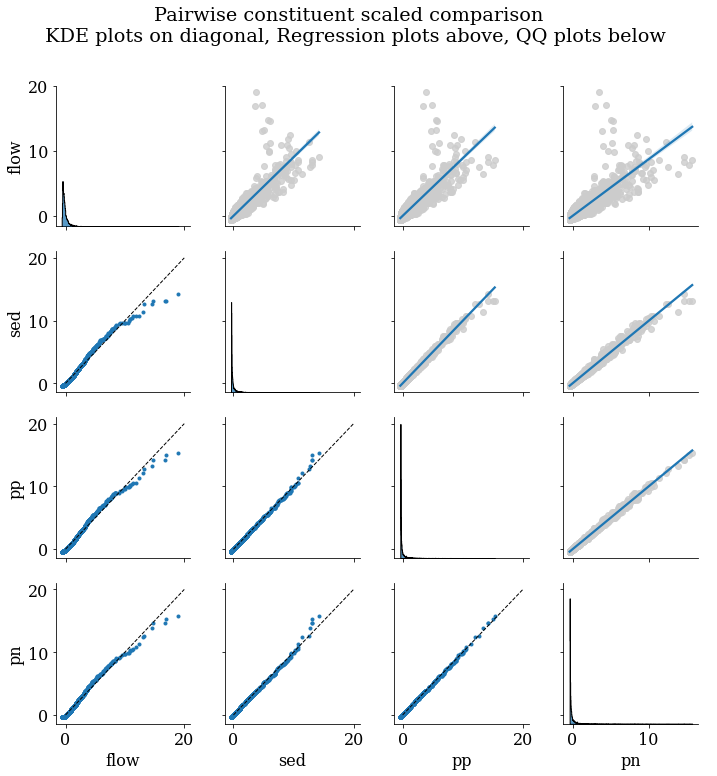

In [ ]:
def qqplot(x, y, **kwargs):
    _, xr = stats.probplot(x, fit=False)
    _, yr = stats.probplot(y, fit=False)
    lims = [
            np.min([0, 0]),  # min of both axes
            np.max([20, 20]),  # max of both axes
]
    plt.plot(lims, lims, linestyle='--', color='k', lw=1, scalex=True, scaley=True)
    plt.scatter(xr, yr, **kwargs)
    
g = sns.PairGrid(df, palette="Set2") #, corner = True)
g.map_upper(sns.regplot, fit_reg=True, ci = 90, scatter_kws = {'color' : '#cccccccc'})
g.map_lower(qqplot, marker='.')
g.map_diag(sns.histplot, multiple="stack", element="step")
g.add_legend()
g.fig.suptitle('Pairwise constituent scaled comparison \n KDE plots on diagonal, Regression plots above, QQ plots below', y=1.08)  

In [ ]:

van_dict = {}
ewm_dict = {}
rip_dict = {}

for constit in constituents_:
  van_dict[constit] = {}
  ewm_dict[constit] = {}
  rip_dict[constit] = {}

  upper_v  = eval_dict[constit]['van'][m_s]['pred_dist'].max(axis=0)
  lower_v = eval_dict[constit]['van'][m_s]['pred_dist'].min(axis=0)
      
  lower_e = eval_dict[constit]['ewm'][m_s]['pred_dist'].min(axis=0)
  upper_e = eval_dict[constit]['ewm'][m_s]['pred_dist'].max(axis=0)

  lower_r = eval_dict[constit]['rip'][m_s]['pred_dist'].min(axis=0)
  upper_r = eval_dict[constit]['rip'][m_s]['pred_dist'].max(axis=0)

  for m_s in ['pgbm']:
    van_dict[constit][m_s] = {}
    ewm_dict[constit][m_s] = {}
    rip_dict[constit][m_s] = {}

    for k in np.arange(0,1,.001):
      new_up_v = (upper_v+lower_v + k*(upper_v-lower_v))/2
      
      new_low_v = (upper_v+lower_v - k*(upper_v-lower_v))/2 

      new_up_e = (upper_e+lower_e + k*(upper_e-lower_e))/2
      new_low_e = (upper_e+lower_e - k*(upper_e-lower_e))/2     

      new_up_r = (upper_r+lower_r + k*(upper_r-lower_r))/2
      new_low_r = (upper_r+lower_r - k*(upper_r-lower_r))/2

      van_dict[constit][m_s][PICP(all_models[constit]['van'][m_s].y_te, new_low_v, new_up_v)] = (k, MPI(new_low_v,new_up_v), PICP(all_models[constit]['van'][m_s].y_te, new_low_v, new_up_v))
      ewm_dict[constit][m_s][PICP(all_models[constit]['ewm'][m_s].y_te, new_low_e, new_up_e)] = (k, MPI(new_low_e,new_up_e), PICP(all_models[constit]['ewm'][m_s].y_te, new_low_e, new_up_e))
      rip_dict[constit][m_s][PICP(all_models[constit]['rip'][m_s].y_te, new_low_r, new_up_r)] = (k, MPI(new_low_r,new_up_r), PICP(all_models[constit]['rip'][m_s].y_te, new_low_r, new_up_r))


In [ ]:
k_dict = {}

for constit in constituents_:
  k_dict[constit] = {}

  for key in van_dict[constit]['pgbm'].keys():
    if key > .90 and key < .922:
      k_dict[constit]['van'] = van_dict[constit]['pgbm'][key]
      print('van', constit, k_dict[constit]['van'])
      break

  for key in ewm_dict[constit]['pgbm'].keys():
    if key > .90 and key < .92:
      k_dict[constit]['ewm'] = ewm_dict[constit]['pgbm'][key]
      print('ewm', constit, k_dict[constit]['ewm'])
      break
      
  for key in rip_dict[constit]['pgbm'].keys():
    if key > .90 and key < .92:
      k_dict[constit]['rip'] = rip_dict[constit]['pgbm'][key]
      print('rip', constit, k_dict[constit]['rip'])
      break


van pn (0.988, 17896.830603521998, 0.9063301967493584)
ewm pn (0.985, 12826.385514995294, 0.9093242087254063)
rip pn (0.33, 2629.512992547309, 0.9002141327623127)
van pp (0.99, 6892.650194569831, 0.9114627887082977)
ewm pp (0.987, 4402.476469330917, 0.9110350727117195)
rip pp (0.966, 1767.8370004957414, 0.902355460385439)
van sed (0.965, 1422571.4100141216, 0.9011976047904192)
ewm sed (0.96, 1190278.4728723764, 0.9020530367835757)
rip sed (0.924, 697094.6883460964, 0.9010706638115632)


<BarContainer object of 3 artists>

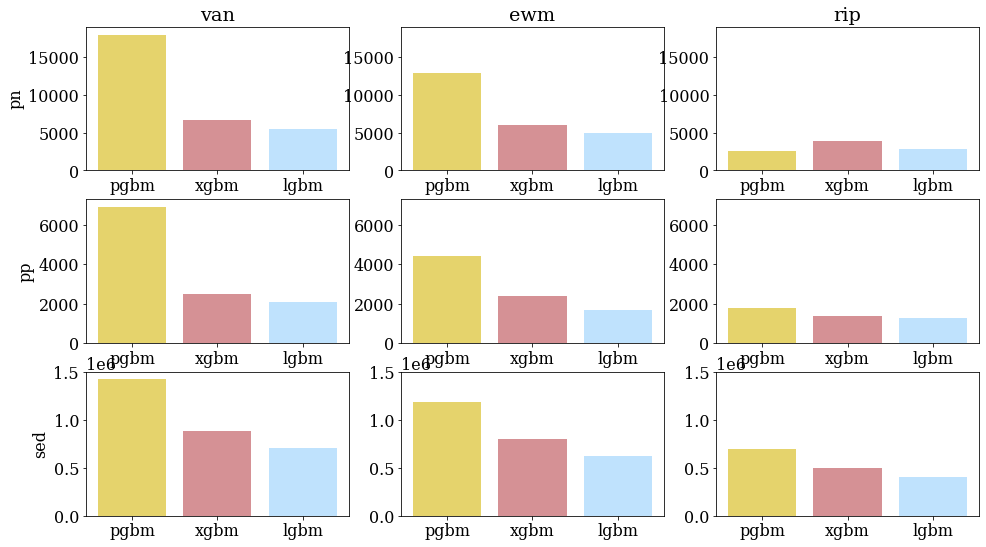

In [ ]:
colors = {'lgbm': 'xkcd:Light Blue', 'pgbm': 'xkcd:Dark Yellow', 'xgbm': 'xkcd:Dusty Red'}
plt.subplot(3, 3, 1)
plt.xticks([1,2,3],['pgbm', 'xgbm', 'lgbm'])
plt.title('van')
plt.ylabel('pn')
plt.ylim(0,19000)
plt.bar([1,2,3],
        [k_dict['pn']['van'][1], eval_dict['pn']['van']['xgbm']['MPI'], eval_dict['pn']['van']['lgbm']['MPI']],
        color = [colors['pgbm'], colors['xgbm'], colors['lgbm']],
        alpha = .6)
plt.subplot(3, 3, 2)
plt.xticks([1,2,3],['pgbm', 'xgbm', 'lgbm'])
plt.title('ewm')
plt.ylim(0,19000)
plt.bar([1,2,3],
        [k_dict['pn']['ewm'][1], eval_dict['pn']['ewm']['xgbm']['MPI'], eval_dict['pn']['ewm']['lgbm']['MPI']],
        color = [colors['pgbm'], colors['xgbm'], colors['lgbm']],
        alpha = .6)
plt.subplot(3, 3, 3)
plt.xticks([1,2,3],['pgbm', 'xgbm', 'lgbm'])
plt.title('rip')
plt.ylim(0,19000)
plt.bar([1,2,3],
        [k_dict['pn']['rip'][1],
        eval_dict['pn']['rip']['xgbm']['MPI'], eval_dict['pn']['rip']['lgbm']['MPI']],
        color = [colors['pgbm'], colors['xgbm'], colors['lgbm']],
        alpha = .6)
plt.subplot(3, 3, 4)
plt.xticks([1,2,3],['pgbm', 'xgbm', 'lgbm'])
plt.ylabel('pp')
plt.ylim(0,7300)
plt.bar([1,2,3],
        [k_dict['pp']['van'][1], eval_dict['pp']['van']['xgbm']['MPI'], eval_dict['pp']['van']['lgbm']['MPI']],
        color = [colors['pgbm'], colors['xgbm'], colors['lgbm']],
        alpha = .6)
plt.subplot(3, 3, 5)
plt.xticks([1,2,3],['pgbm', 'xgbm', 'lgbm'])
plt.ylim(0,7300)
plt.bar([1,2,3],
        [k_dict['pp']['ewm'][1], eval_dict['pp']['ewm']['xgbm']['MPI'], eval_dict['pp']['ewm']['lgbm']['MPI']],
        color = [colors['pgbm'], colors['xgbm'], colors['lgbm']],
        alpha = .6)
plt.subplot(3, 3, 6)
plt.xticks([1,2,3],['pgbm', 'xgbm', 'lgbm'])
plt.ylim(0,7300)
plt.bar([1,2,3],
        [k_dict['pp']['rip'][1], eval_dict['pp']['rip']['xgbm']['MPI'], eval_dict['pp']['rip']['lgbm']['MPI']],
        color = [colors['pgbm'], colors['xgbm'], colors['lgbm']],
        alpha = .6)
plt.subplot(3, 3, 7)
plt.xticks([1,2,3],['pgbm', 'xgbm', 'lgbm'])
plt.ylabel('sed')
plt.ylim(0,1500000)
plt.bar([1,2,3],
        [k_dict['sed']['van'][1], eval_dict['sed']['van']['xgbm']['MPI'], eval_dict['sed']['van']['lgbm']['MPI']],
        color = [colors['pgbm'], colors['xgbm'], colors['lgbm']],
        alpha = .6)
plt.subplot(3, 3, 8)
plt.xticks([1,2,3],['pgbm', 'xgbm', 'lgbm'])
plt.ylim(0,1500000)
plt.bar([1,2,3],
        [k_dict['sed']['ewm'][1], eval_dict['sed']['ewm']['xgbm']['MPI'], eval_dict['sed']['ewm']['lgbm']['MPI']],
        color = [colors['pgbm'], colors['xgbm'], colors['lgbm']],
        alpha = .6)
plt.subplot(3, 3, 9)
plt.ylim(0,1500000)
plt.xticks([1,2,3],['pgbm', 'xgbm', 'lgbm'])
plt.bar([1,2,3],
        [k_dict['sed']['rip'][1], eval_dict['sed']['rip']['xgbm']['MPI'], eval_dict['sed']['rip']['lgbm']['MPI']],
        color = [colors['pgbm'], colors['xgbm'], colors['lgbm']],
        alpha = .6)


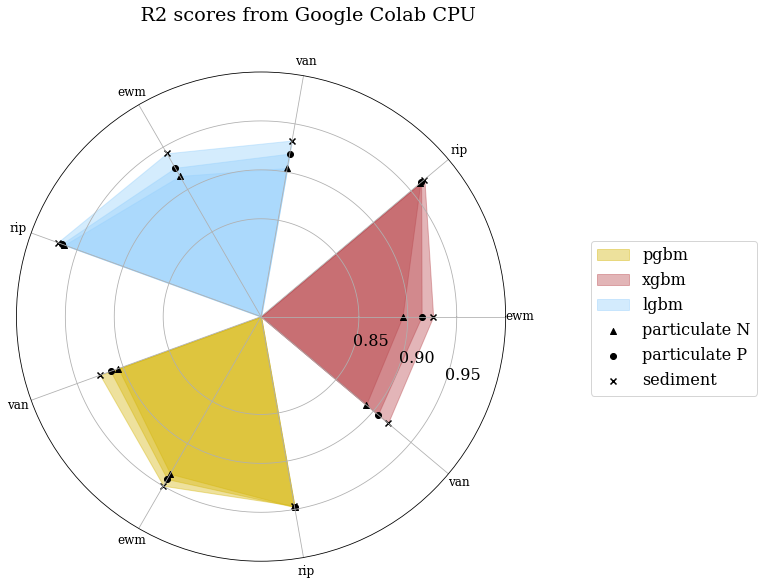

In [ ]:
colors = {'lgbm': 'xkcd:Light Blue', 'pgbm': 'xkcd:Dark Yellow', 'xgbm': 'xkcd:Dusty Red'}
plt.rcParams["figure.figsize"] = (16,9)

fig, ax = plt.subplots( subplot_kw={'projection': 'polar'})

ax = plt.subplot(111,polar=True)
ax.set_rlabel_position(-20)  # Move radial labels away from plotted line
rads = [i*360/9 for i in range(9)]


r = [eval_dict['pn'][j][i]['r2_score'] for i in models_sets for j in data_sets]
r2 = [eval_dict['pp'][j][i]['r2_score'] for i in models_sets for j in data_sets]
r3 = [eval_dict['sed'][j][i]['r2_score'] for i in models_sets for j in data_sets]
theta = [i*360/9 for i in range(len(r))]
ax.set_thetagrids(rads, ['ewm','rip','van','ewm','rip','van','ewm','rip','van'], fontsize = 12)

ax.fill_between([-2*np.pi/9+2*i*np.pi/9 for i in range(3)],
    .75,        
    r3[:3],
    color = colors['xgbm'],
    alpha = .4)

ax.fill_between([-2*np.pi/9+2*i*np.pi/9 for i in range(3,6,1)],
    .75,        
    r3[3:6],
    color = colors['lgbm'],
    alpha = .4)

ax.fill_between([-2*np.pi/9+2*i*np.pi/9 for i in range(6,9,1)],
    .75,        
    r3[6:9],
    color = colors['pgbm'],
    alpha = .4)

ax.fill_between([-2*np.pi/9+2*i*np.pi/9 for i in range(3)],
    .75,        
    r2[:3],
    color = colors['xgbm'],
    alpha = .4)

ax.fill_between([-2*np.pi/9+2*i*np.pi/9 for i in range(3,6,1)],
    .75,        
    r2[3:6],
    color = colors['lgbm'],
    alpha = .4)

ax.fill_between([-2*np.pi/9+2*i*np.pi/9 for i in range(6,9,1)],
    .75,        
    r2[6:9],
    color = colors['pgbm'],
    label = 'pgbm',
    alpha = .4)

ax.fill_between([-2*np.pi/9+2*i*np.pi/9 for i in range(3)],
    .75,        
    r[:3],
    color = colors['xgbm'],
    label = 'xgbm',
    alpha = .4)

ax.fill_between([-2*np.pi/9+2*i*np.pi/9 for i in range(3,6,1)],
    .75,        
    r[3:6],
    color = colors['lgbm'],
    label = 'lgbm',
    alpha = .4)

ax.fill_between([-2*np.pi/9+2*i*np.pi/9 for i in range(6,9,1)],
    .75,        
    r[6:9],
    color = colors['pgbm'],
    alpha = .4)

ax.scatter([-2*np.pi/9+2*i*np.pi/9 for i in range(len(r))], r, c= ['k'], label = 'particulate N', marker='^')
ax.scatter([-2*np.pi/9+2*i*np.pi/9 for i in range(len(r2))], r2, c= ['k'], label = 'particulate P', marker = 'o')
ax.scatter([-2*np.pi/9+2*i*np.pi/9 for i in range(len(r3))], r3, c= ['k'], label = 'sediment', marker='x')
plt.suptitle('                    R2 scores from Google Colab CPU')
ax.set_rmax(1.0)
ax.set_rmin(.75)
ax.set_rticks([0.85, .9, .95])  # Less radial ticks
plt.legend(bbox_to_anchor=(.95,0.5),loc="center right",fontsize=16, bbox_transform=plt.gcf().transFigure)
plt.show()

In [ ]:
args = {'constit': 'sed',
        'elem': obj._df.columns[0][1],
        'method': 'ewm',
        'date': dates}

_data_  =  obj.train_test_val(.1,None,0,.2,None,0,None,**args)

df = pd.DataFrame([pd.Series(eval_dict['sed']['ewm']['pgbm']['pred'],
                             name = 'pgbm',
                             index = _data_[0][3].index),
                   pd.Series(eval_dict['sed']['ewm']['xgbm']['pred'],
                             name = 'xgbm',
                             index = _data_[0][3].index),
                   pd.Series(eval_dict['sed']['ewm']['lgbm']['pred'],
                             name = 'lgbm',
                             index = _data_[0][3].index),
                   pd.Series(_data_[0][3],
                             name = 'target')]).T

print(df.index[0].month)

tr_te_val
tr_te
X_y
adding ewm
('sed_data', 'link for catchment SC #119') <class 'pandas.core.series.Series'>
6


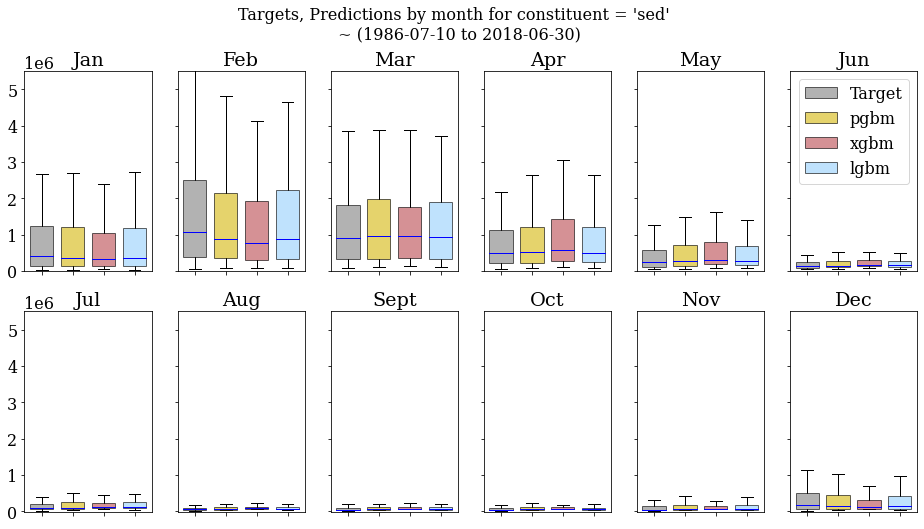

In [ ]:
fig, ax = plt.subplots(2,6, sharey = 'row', sharex = True)
fig.suptitle("Targets, Predictions by month for constituent = '{}' \n ~ ({} to {})".format(constit, str(df.index.min())[:10],
                                                                                          str(df.index.max())[:10] ), fontsize=16)
fig.autofmt_xdate(rotation=45)
labels = ['']
colors = {'lgbm': 'xkcd:Light Blue', 'pgbm': 'xkcd:Dark Yellow', 'xgbm': 'xkcd:Dusty Red'}

months_ = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
pos = np.array([200, 400, 600, 800])
months = ['blank', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']


for idx, i in enumerate([1,2,3,4,5,6,7,8,9,10,11, 12]):
  bplot1 = ax[(idx)//6,(idx)%6].boxplot(df[df.index.month == i]['target'],0,'',
                                        positions= [200],
                                        widths=150,
                                        patch_artist=True,
                                        #showmeans = True,
                                        #meanline = True,
                                        medianprops = {'color': 'b'},
                                        #meanprops = {'marker':'x'}
                                        )
  for patch in bplot1['boxes']:
        patch.set(facecolor='grey', alpha =.6)
  bplot2 = ax[(idx)//6,(idx)%6].boxplot(df[df.index.month == i]['pgbm'],0,'',
                                        positions= [400],
                                        widths=150,
                                        patch_artist=True,
                                        #showmeans = True,
                                        #meanline = True,
                                        medianprops = {'color': 'b'},
                                        #meanprops = {'marker':'x'}
                                        )
  for patch in bplot2['boxes']:
        patch.set(facecolor=colors['pgbm'], alpha =.6)
  bplot3 = ax[(idx)//6,(idx)%6].boxplot(df[df.index.month == i]['xgbm'],0,'',
                                        positions= [600],
                                        widths=150,
                                        patch_artist=True,
                                        #showmeans = True,
                                        #meanline = True,
                                        medianprops = {'color': 'b'},
                                        #meanprops = {'marker':'x'}
                                        )
  for patch in bplot3['boxes']:
        patch.set(facecolor=colors['xgbm'], alpha =.6)
  bplot4 = ax[(idx)//6,(idx)%6].boxplot(df[df.index.month == i]['lgbm'],0,'',
                                        positions= [800],
                                        widths=150,
                                        patch_artist=True,
                                        #showmeans = True,
                                        #meanline = True,
                                        medianprops = {'color': 'b'},
                                        #meanprops = {'marker':'x'}
                                        )
  for patch in bplot4['boxes']:
        patch.set(facecolor=colors['lgbm'], alpha =.6)
  ax[(idx)//6,(idx)%6].set_title(months[i])
  ax[(idx)//6,(idx)%6].set_xticks(pos)
  if idx > 6:
    ax[(idx)//6,(idx)%6].set( axisbelow=True,
           xticklabels=[])
  
  if idx%6:
    ax[(idx)//6,(idx)%6].set(ylim = (-10000,5500000))
    ax[(idx)//6,(idx)%6].tick_params(axis ='y', which = 'both',labelsize=10)
    #ax[(idx)//6,(idx)%6].legend([bplot1["boxes"][0], bplot2["boxes"][0]], ['Target', 'pgbm'])
  if idx == 5:
    ax[(idx)//6,(idx)%6].legend([bplot1["boxes"][0], bplot2["boxes"][0], bplot3['boxes'][0], bplot4['boxes'][0]], ['Target', 'pgbm', 'xgbm','lgbm'])

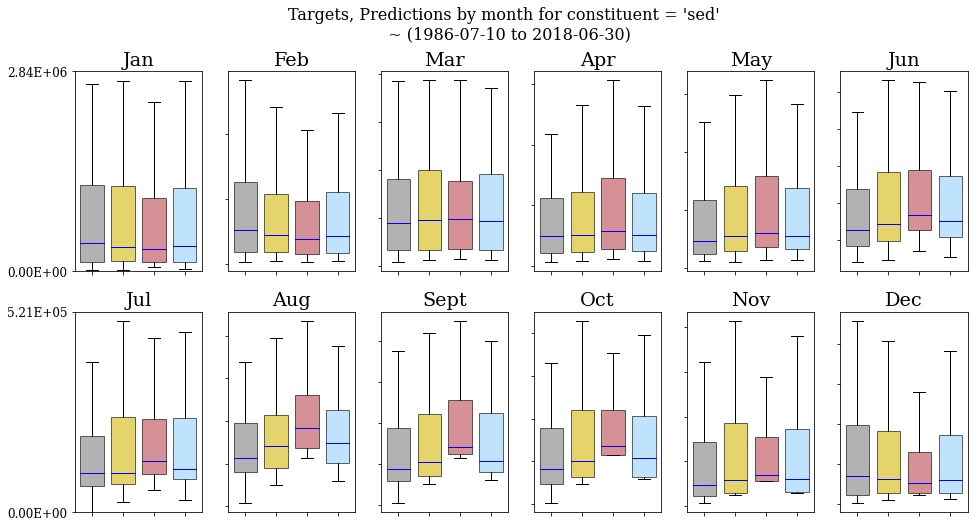

In [ ]:
fig, ax = plt.subplots(2,6, sharey = False, sharex = True)
fig.suptitle("Targets, Predictions by month for constituent = '{}' \n ~ ({} to {})".format(constit, str(df.index.min())[:10],
                                                                                          str(df.index.max())[:10] ), fontsize=16)
fig.autofmt_xdate(rotation=45)
labels = ['']
colors = {'lgbm': 'xkcd:Light Blue', 'pgbm': 'xkcd:Dark Yellow', 'xgbm': 'xkcd:Dusty Red'}

months_ = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
pos = np.array([200, 400, 600, 800])
months = ['blank', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']


for idx, i in enumerate([1,2,3,4,5,6,7,8,9,10,11, 12]):
  bplot1 = ax[(idx)//6,(idx)%6].boxplot(df[df.index.month == i]['target'],0,'',
                                        positions= [200],
                                        widths=150,
                                        patch_artist=True,
                                        #showmeans = True,
                                        #meanline = True,
                                        medianprops = {'color': 'b'},
                                        #meanprops = {'marker':'x'}
                                        )
  for patch in bplot1['boxes']:
        patch.set(facecolor='grey', alpha =.6)
  bplot2 = ax[(idx)//6,(idx)%6].boxplot(df[df.index.month == i]['pgbm'],0,'',
                                        positions= [400],
                                        widths=150,
                                        patch_artist=True,
                                        #showmeans = True,
                                        #meanline = True,
                                        medianprops = {'color': 'b'},
                                        #meanprops = {'marker':'x'}
                                        )
  for patch in bplot2['boxes']:
        patch.set(facecolor=colors['pgbm'], alpha =.6)
  bplot3 = ax[(idx)//6,(idx)%6].boxplot(df[df.index.month == i]['xgbm'],0,'',
                                        positions= [600],
                                        widths=150,
                                        patch_artist=True,
                                        #showmeans = True,
                                        #meanline = True,
                                        medianprops = {'color': 'b'},
                                        #meanprops = {'marker':'x'}
                                        )
  for patch in bplot3['boxes']:
        patch.set(facecolor=colors['xgbm'], alpha =.6)
  bplot4 = ax[(idx)//6,(idx)%6].boxplot(df[df.index.month == i]['lgbm'],0,'',
                                        positions= [800],
                                        widths=150,
                                        patch_artist=True,
                                        #showmeans = True,
                                        #meanline = True,
                                        medianprops = {'color': 'b'},
                                        #meanprops = {'marker':'x'}
                                        )
  for patch in bplot4['boxes']:
        patch.set(facecolor=colors['lgbm'], alpha =.6)
  ax[(idx)//6,(idx)%6].set_title(months[i])
  ax[(idx)//6,(idx)%6].set_xticks(pos)
  if idx > 6:
    ax[(idx)//6,(idx)%6].set( axisbelow=True,
           xticklabels=[],
           yticklabels = [])
  else: 
    ax[(idx)//6,(idx)%6].set( axisbelow=True,
           xticklabels=[],
           yticklabels = [])
  if not idx%6:
    ax[(idx)//6,(idx)%6].set(ylim = [0,ax[(idx)//6,(idx)%6].get_ylim()[1]])
    ax[(idx)//6,(idx)%6].tick_params(labelsize=12)
    ax[(idx)//6,(idx)%6].set( yticks = ax[(idx)//6,(idx)%6].get_ylim(), yticklabels = ['{:.2E}'.format(i)for i in ax[(idx)//6,(idx)%6].get_ylim()])
    pass
  
#plt.legend([bplot1["boxes"][0], bplot2["boxes"][0], bplot3['boxes'][0], bplot4['boxes'][0]], ['Target', 'pgbm', 'xgbm','lgbm'])



/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


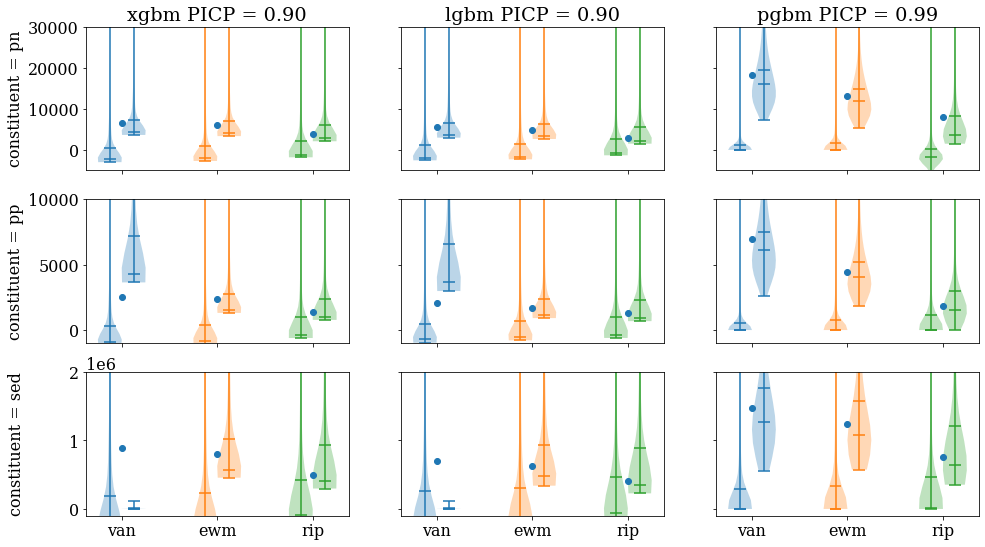

In [ ]:
fig, axs = plt.subplots(3,3, sharey='row')
i = 0
for constit in constituents_:
  for m_s in models_sets:
    if not i%3:
      if constit == 'sed':
        axs[i//3,i%3].set_ylabel('constituent = {}\n\n'.format(constit))
      else:
        axs[i//3,i%3].set_ylabel('constituent = {}'.format(constit))
    if m_s =='pgbm':      
        data = [eval_dict[constit]['van'][m_s]['pred_dist'].min(axis=0)]
        data.append([eval_dict[constit]['van'][m_s]['pred_dist'].max(axis=0)])

        data1 = [eval_dict[constit]['ewm'][m_s]['pred_dist'].min(axis=0)]
        data1.append([eval_dict[constit]['ewm'][m_s]['pred_dist'].max(axis=0)])

        data2 = [eval_dict[constit]['rip'][m_s]['pred_dist'].min(axis=0)]
        data2.append([eval_dict[constit]['rip'][m_s]['pred_dist'].max(axis=0)])
    else:
        data = [eval_dict[constit]['van'][m_s]['pred_dist'][:,0]]
        data.append([eval_dict['pn']['van'][m_s]['pred_dist'][:,1]])

        data1 = [eval_dict[constit]['ewm'][m_s]['pred_dist'][:,0]]
        data1.append([eval_dict[constit]['ewm'][m_s]['pred_dist'][:,1]])

        data2 = [eval_dict[constit]['rip'][m_s]['pred_dist'][:,0]]
        data2.append([eval_dict[constit]['rip'][m_s]['pred_dist'][:,1]])
        
    axs[i//3,i%3].violinplot(data, [0,.5], showmeans=True, showmedians=True)
    axs[i//3,i%3].violinplot(data1, [2,2.5], showmeans=True, showmedians=True)
    axs[i//3,i%3].violinplot(data2, [4,4.5], showmeans=True, showmedians=True)

    axs[i//3,i%3].scatter([0.25,2.25,4.25],[eval_dict[constit][i][m_s]['MPI'] for i in data_sets])
    

    if constit == 'sed':
      axs[i//3,i%3].set_ylim(-100000,2000000)
    elif constit == 'pn':
      axs[i//3,i%3].set_ylim(-5000,30000)
    elif constit == 'pp':
      axs[i//3,i%3].set_ylim(-1000,10000)


    if i < 3:
      axs[i//3,i%3].set_title('{} PICP = {:.2f}'.format(m_s, np.array([eval_dict[constit][i][m_s]['PICP'] for i in data_sets]).mean()))
    axs[i//3,i%3].set_xticks([0.25,2.25,4.25])
    axs[i//3,i%3].set_xticklabels([])
    if i > 5:
      axs[i//3,i%3].set_xticklabels(['van','ewm','rip'])
    i +=1
plt.show()

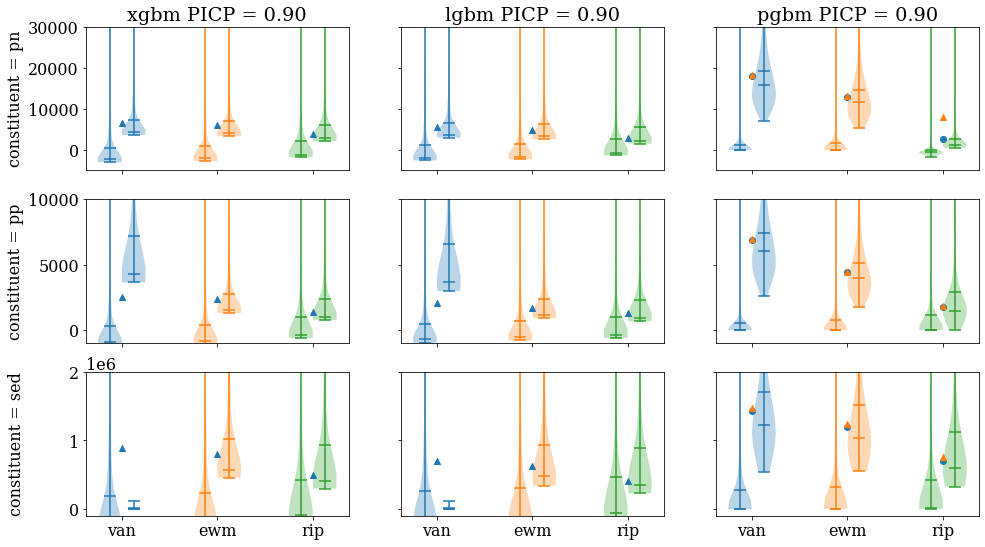

In [ ]:
fig, axs = plt.subplots(3,3, sharey='row')
i = 0
for constit in constituents_:
  for m_s in models_sets:
    if not i%3:
      if constit == 'sed':
        axs[i//3,i%3].set_ylabel('constituent = {}\n\n'.format(constit))
      else:
        axs[i//3,i%3].set_ylabel('constituent = {}'.format(constit))
    if m_s =='pgbm':
      dist = eval_dict[constit]['van'][m_s]['pred_dist']*k_dict[constit]['van'][0]
      data = [dist.min(axis=0)]
      data.append([dist.max(axis=0)])

      dist1 = eval_dict[constit]['ewm'][m_s]['pred_dist']*k_dict[constit]['ewm'][0]
      data1 = [dist1.min(axis=0)]
      data1.append([dist1.max(axis=0)])

      dist2 = eval_dict[constit]['rip'][m_s]['pred_dist']*k_dict[constit]['rip'][0]
      data2 = [dist2.min(axis=0)]
      data2.append([dist2.max(axis=0)])

      axs[i//3,i%3].scatter([0.25,2.25,4.25],[k_dict[constit][i][1] for i in data_sets])

    else:
        data = [eval_dict[constit]['van'][m_s]['pred_dist'][:,0]]
        data.append([eval_dict['pn']['van'][m_s]['pred_dist'][:,1]])

        data1 = [eval_dict[constit]['ewm'][m_s]['pred_dist'][:,0]]
        data1.append([eval_dict[constit]['ewm'][m_s]['pred_dist'][:,1]])

        data2 = [eval_dict[constit]['rip'][m_s]['pred_dist'][:,0]]
        data2.append([eval_dict[constit]['rip'][m_s]['pred_dist'][:,1]])
        
    axs[i//3,i%3].violinplot(data, [0,.5], showmedians=True, showmeans=True)
    axs[i//3,i%3].violinplot(data1, [2,2.5], showmedians=True, showmeans=True)
    axs[i//3,i%3].violinplot(data2, [4,4.5], showmedians=True, showmeans=True)

    #axs[i//3,i%3].scatter([0.25,2.25,4.25],[k_dict[constit][i][1] for i in data_sets])
    axs[i//3,i%3].scatter([0.25,2.25,4.25],[eval_dict[constit][i][m_s]['MPI'] for i in data_sets], marker = '^')
    #axs[i//3,i%3].scatter([0.25,2.25,4.25],[eval_dict[constit][i][m_s]['NMPI'].max() for i in data_sets])


    if constit == 'sed':
      axs[i//3,i%3].set_ylim(-100000,2000000)
    elif constit == 'pn':
      axs[i//3,i%3].set_ylim(-5000,30000)
    elif constit == 'pp':
      axs[i//3,i%3].set_ylim(-1000,10000)

    if i < 2:
      axs[i//3,i%3].set_title('{} PICP = {:.2f}'.format(m_s, np.array([eval_dict[constit][i][m_s]['PICP'] for i in data_sets]).mean()))
    if i == 2:
      axs[i//3,i%3].set_title('{} PICP = {:.2f}'.format(m_s, np.array([k_dict[constit][i][2] for i in data_sets]).mean()-.01))
    axs[i//3,i%3].set_xticks([0.25,2.25,4.25])
    axs[i//3,i%3].set_xticklabels([])
    if i > 5:
      axs[i//3,i%3].set_xticklabels(['van','ewm','rip'])
    i +=1
plt.show()

In [ ]:
df = pd.DataFrame([pd.Series(eval_dict['sed']['ewm']['pgbm']['pred'],
                             name = 'pgbm',
                             index = _data_[0][3].index),
                   pd.Series(eval_dict['sed']['ewm']['pgbm']['pred_dist'].min(axis=0),
                             name = 'pgbm_l',
                             index = _data_[0][3].index),
                   pd.Series(eval_dict['sed']['ewm']['pgbm']['pred_dist'].max(axis=0),
                             name = 'pgbm_u',
                             index = _data_[0][3].index),
                   pd.Series(eval_dict['sed']['ewm']['xgbm']['pred'],
                             name = 'xgbm',                             
                             index = _data_[0][3].index),
                   pd.Series(eval_dict['sed']['ewm']['xgbm']['pred_dist'][:,0],
                             name = 'xgbm_l',                             
                             index = _data_[0][3].index),
                   pd.Series(eval_dict['sed']['ewm']['xgbm']['pred_dist'][:,1],
                             name = 'xgbm_u',                             
                             index = _data_[0][3].index),                   
                   pd.Series(eval_dict['sed']['ewm']['lgbm']['pred'],
                             name = 'lgbm',
                             index = _data_[0][3].index),
                   pd.Series(eval_dict['sed']['ewm']['lgbm']['pred_dist'][:,0],
                             name = 'lgbm_l',
                             index = _data_[0][3].index),
                   pd.Series(eval_dict['sed']['ewm']['lgbm']['pred_dist'][:,1],
                             name = 'lgbm_u',                             
                             index = _data_[0][3].index),
                   pd.Series(_data_[0][3],
                             name = 'target')]).T
print(df.info())                            


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2338 entries, 2017-06-19 to 1986-09-22
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pgbm    2338 non-null   float64
 1   pgbm_l  2338 non-null   float64
 2   pgbm_u  2338 non-null   float64
 3   xgbm    2338 non-null   float64
 4   xgbm_l  2338 non-null   float64
 5   xgbm_u  2338 non-null   float64
 6   lgbm    2338 non-null   float64
 7   lgbm_l  2338 non-null   float64
 8   lgbm_u  2338 non-null   float64
 9   target  2338 non-null   float64
dtypes: float64(10)
memory usage: 265.5 KB
None


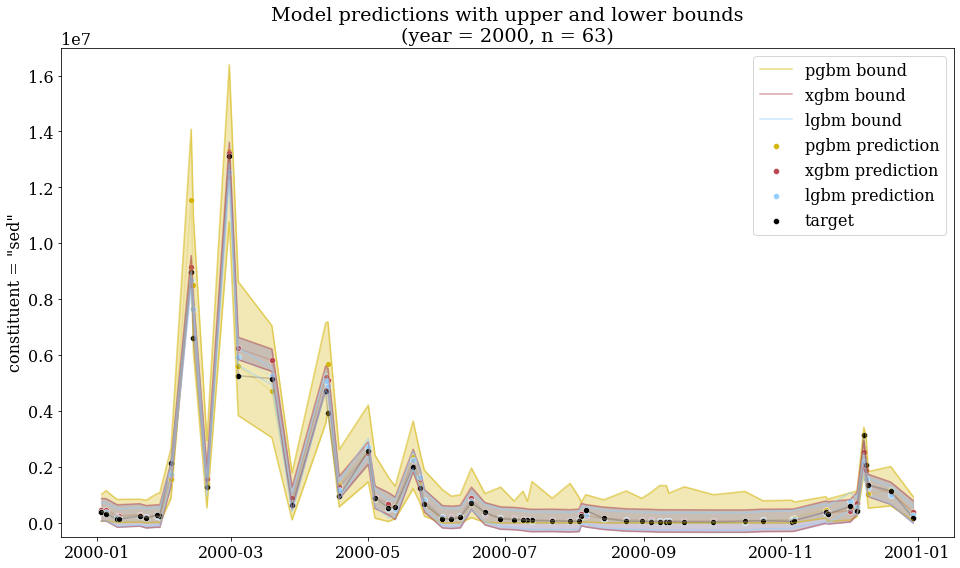

In [ ]:
yr = 2000

a=sns.lineplot(x=df[df.index.year == yr].index, y=df[df.index.year == yr]['pgbm'], color=colors['pgbm'], alpha = .2)
b=sns.lineplot(x=df[df.index.year == yr].index, y=df[df.index.year == yr]['pgbm_l'], color=colors['pgbm'], label='pgbm bound', alpha = .5)
c=sns.lineplot(x=df[df.index.year == yr].index, y=df[df.index.year == yr]['pgbm_u'], color=colors['pgbm'], alpha = .5)

line = c.get_lines()
plt.fill_between(line[0].get_xdata(), line[1].get_ydata(), line[2].get_ydata(), color=colors['pgbm'], alpha=.3)
d2 = sns.lineplot(x=df[df.index.year == yr].index, y=df[df.index.year == yr]['target'],  color='k',alpha = .2)

a1=sns.lineplot(x=df[df.index.year == yr].index, y=df[df.index.year == yr]['xgbm'], color=colors['xgbm'], alpha = .2)
b1=sns.lineplot(x=df[df.index.year == yr].index, y=df[df.index.year == yr]['xgbm_l'], color=colors['xgbm'],label='xgbm bound', alpha = .5)
c1=sns.lineplot(x=df[df.index.year == yr].index, y=df[df.index.year == yr]['xgbm_u'], color=colors['xgbm'], alpha = .5)

line1 = c1.get_lines()
plt.fill_between(line1[-3].get_xdata(), line1[-2].get_ydata(), line1[-1].get_ydata(), color=colors['xgbm'], alpha=.3)

a2=sns.lineplot(x=df[df.index.year == yr].index, y=df[df.index.year == yr]['lgbm'], color=colors['lgbm'], alpha = .2)
b2=sns.lineplot(x=df[df.index.year == yr].index, y=df[df.index.year == yr]['lgbm_l'], color=colors['lgbm'], label='lgbm bound', alpha = .5)
c2=sns.lineplot(x=df[df.index.year == yr].index, y=df[df.index.year == yr]['lgbm_u'], color=colors['lgbm'], alpha = .5)

line2 = c2.get_lines()
plt.fill_between(line1[-3].get_xdata(), line1[-2].get_ydata(), line1[-1].get_ydata(), color=colors['lgbm'], alpha=.3)

t = sns.scatterplot(x=df[df.index.year == yr].index, y=df[df.index.year == yr]['pgbm'], label = 'pgbm prediction',color=colors['pgbm'])
t3 = sns.scatterplot(x=df[df.index.year == yr].index, y=df[df.index.year == yr]['xgbm'], label = 'xgbm prediction',color=colors['xgbm'])
t4 = sns.scatterplot(x=df[df.index.year == yr].index, y=df[df.index.year == yr]['lgbm'], label = 'lgbm prediction',color=colors['lgbm'])

t1 = sns.scatterplot(x=df[df.index.year == yr].index, y=df[df.index.year == yr]['target'], label='target', color='k')

plt.legend()
plt.title('Model predictions with upper and lower bounds\n(year = {}, n = {})'.format(yr, len(df[df.index.year == yr].index)))
plt.ylabel('constituent = "sed"')
plt.ylim(-500000, 17000000)
plt.show()

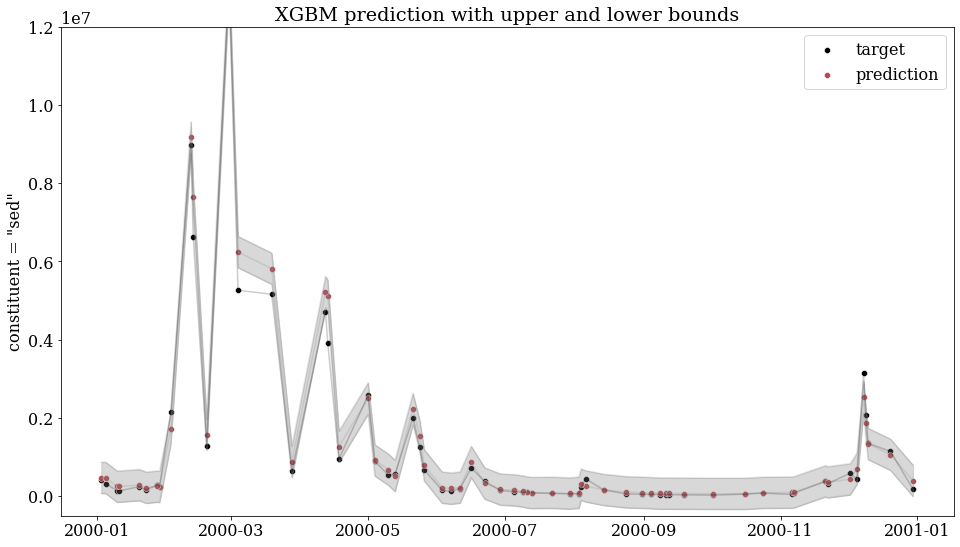

In [ ]:
t1 = sns.scatterplot(x=df[df.index.year == yr].index, y=df[df.index.year == yr]['target'], label='target', color='k')
t = sns.scatterplot(x=df[df.index.year == yr].index, y=df[df.index.year == yr]['xgbm'], label = 'prediction',color=colors['xgbm'])

a=sns.lineplot(x=df[df.index.year == yr].index, y=df[df.index.year == yr]['xgbm'], color='grey', alpha = .2)
b=sns.lineplot(x=df[df.index.year == yr].index, y=df[df.index.year == yr]['xgbm_l'], color='grey', alpha = .2)
c=sns.lineplot(x=df[df.index.year == yr].index, y=df[df.index.year == yr]['xgbm_u'], color='grey', alpha = .2)

line = c.get_lines()
plt.fill_between(line[0].get_xdata(), line[1].get_ydata(), line[2].get_ydata(), color='grey', alpha=.3)
t = sns.lineplot(x=df[df.index.year == yr].index, y=df[df.index.year == yr]['target'],  color='k',alpha = .2)
plt.legend()
plt.title('XGBM prediction with upper and lower bounds')
plt.ylabel('constituent = "sed"')
plt.ylim(-500000, 12000000)
plt.show()

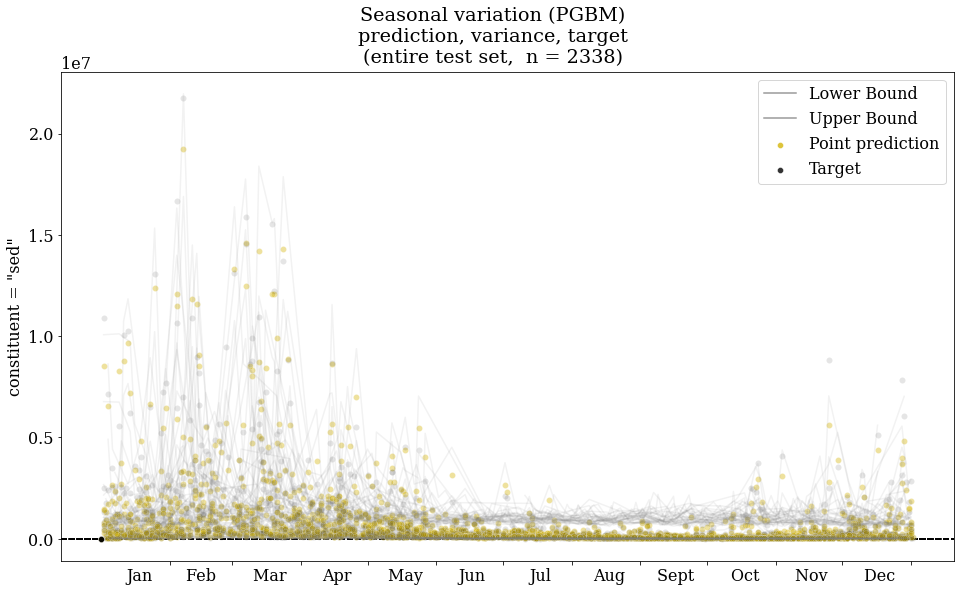

In [ ]:
for yr in df.index.year.unique():
  yr_data = [pd.Period(i, freq='D').dayofyear for i in df[df.index.year == yr].index]
  data = df[df.index.year == yr]
  a=sns.scatterplot(x=yr_data, y=df[df.index.year == yr]['pgbm'], color=colors['pgbm'], alpha=.4) #, label = 'Point prediction')
  b=sns.lineplot(x=yr_data, y=df[df.index.year == yr]['pgbm_l'], color='grey', alpha = .1)#, label = 'Lower bound')
  c=sns.lineplot(x=yr_data, y=df[df.index.year == yr]['pgbm_u'], color='grey', alpha = .1)#, label = 'Upper bound')
  plt.axhline(y = 0, color ="black", linestyle ="--", zorder=0)
  d = sns.scatterplot(x=yr_data, y=df[df.index.year == yr]['target'], color='k', alpha = .1)#, label = "Target")
plt.suptitle("Seasonal variation (PGBM)\nprediction, variance, target\n(entire test set,  n = {})".format(len(df.index)))
plt.xticks([31,31+28,31+28+31,31+28+31+30,31+28+31+30+31,
            31+28+31+30+31+30,31+28+31+30+31+30+31,31+28+31+30+31+30+31+31,
            31+28+31+30+31+30+31+31+30,31+28+31+30+31+30+31+31+30+31,
            31+28+31+30+31+30+31+31+30+31+30,31+28+31+30+31+30+31+31+30+31+30+31],
           labels = [i+'            ' for i in months_])
t_a = sns.scatterplot(x=[0,0], y=[0,0], color=colors['pgbm'], alpha=.8, label = 'Point prediction')
t_b = sns.lineplot(x=[0,0], y=[0,0], color='grey', alpha=.8, label = 'Lower Bound')
t_c = sns.lineplot(x=[0,0], y=[0,0], color='grey', alpha=.8, label = 'Upper Bound')
t_a = sns.scatterplot(x=[0,0], y=[0,0], color='k', alpha=.8, label = 'Target')

#plt.legend()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.ylabel('constituent = "sed"')
plt.legend(by_label.values(), by_label.keys())
plt.show()


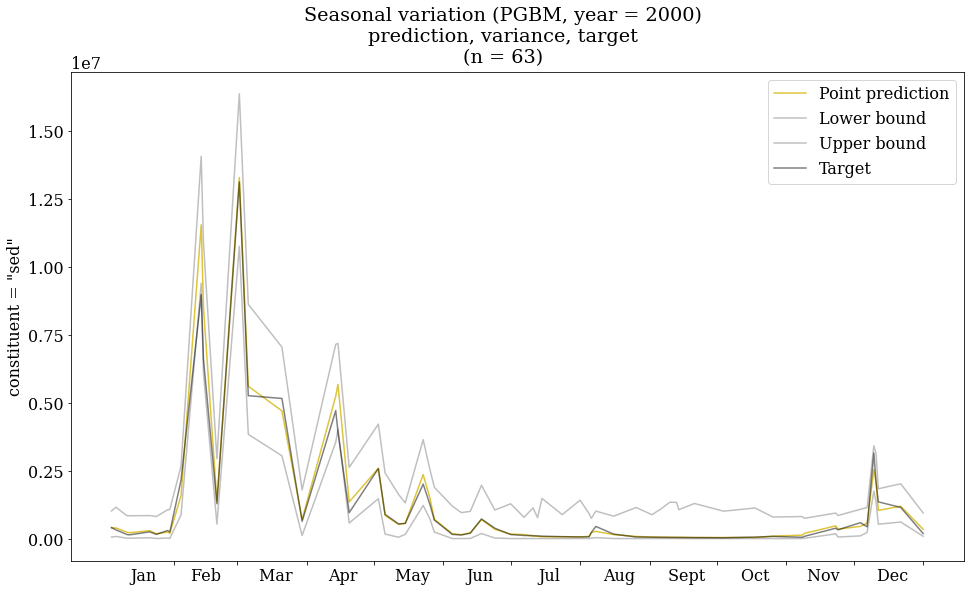

In [ ]:
yr = 2000
for yr in [yr]:
  yr_data = [pd.Period(i, freq='D').dayofyear for i in df[df.index.year == yr].index]
  data = df[df.index.year == yr]
  a=sns.lineplot(x=yr_data, y=df[df.index.year == yr]['pgbm'], color=colors['pgbm'], alpha=.8, label = 'Point prediction')
  b=sns.lineplot(x=yr_data, y=df[df.index.year == yr]['pgbm_l'], color='grey', alpha = .5, label = 'Lower bound')
  c=sns.lineplot(x=yr_data, y=df[df.index.year == yr]['pgbm_u'], color='grey', alpha = .5, label = 'Upper bound')
  d = sns.lineplot(x=yr_data, y=df[df.index.year == yr]['target'], color='k', alpha = .5, label = "Target")

plt.suptitle("Seasonal variation (PGBM, year = {})\nprediction, variance, target\n(n = {})".format(yr, len(data)))
plt.xticks([31,31+28,31+28+31,31+28+31+30,31+28+31+30+31,
            31+28+31+30+31+30,31+28+31+30+31+30+31,31+28+31+30+31+30+31+31,
            31+28+31+30+31+30+31+31+30,31+28+31+30+31+30+31+31+30+31,
            31+28+31+30+31+30+31+31+30+31+30,31+28+31+30+31+30+31+31+30+31+30+31],
           labels = [i+'            ' for i in months_])
plt.ylabel('constituent = "sed"')

plt.legend()
plt.show()

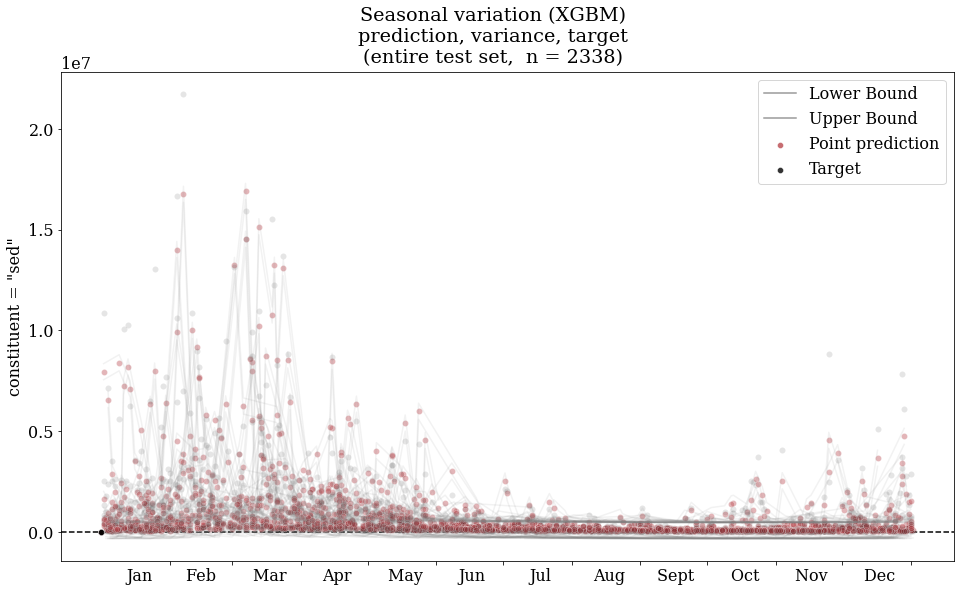

In [ ]:
for yr in df.index.year.unique():
  yr_data = [pd.Period(i, freq='D').dayofyear for i in df[df.index.year == yr].index]
  data = df[df.index.year == yr]
  a=sns.scatterplot(x=yr_data, y=df[df.index.year == yr]['xgbm'], color=colors['xgbm'], alpha=.4)#, label = 'Point prediction')
  b=sns.lineplot(x=yr_data, y=df[df.index.year == yr]['xgbm_l'], color='grey', alpha = .1)#, label = 'Lower bound')
  c=sns.lineplot(x=yr_data, y=df[df.index.year == yr]['xgbm_u'], color='grey', alpha = .1)#, label = 'Upper bound')
  d = sns.scatterplot(x=yr_data, y=df[df.index.year == yr]['target'], color='k', alpha = .1)#, label = "Target")
plt.axhline(y = 0, color ="black", linestyle ="--", zorder=0)
plt.suptitle("Seasonal variation (XGBM)\nprediction, variance, target\n(entire test set,  n = {})".format(len(df.index)))
plt.xticks([31,31+28,31+28+31,31+28+31+30,31+28+31+30+31,
            31+28+31+30+31+30,31+28+31+30+31+30+31,31+28+31+30+31+30+31+31,
            31+28+31+30+31+30+31+31+30,31+28+31+30+31+30+31+31+30+31,
            31+28+31+30+31+30+31+31+30+31+30,31+28+31+30+31+30+31+31+30+31+30+31],
           labels = [i+'            ' for i in months_])
t_a = sns.scatterplot(x=[0,0], y=[0,0], color=colors['xgbm'], alpha=.8, label = 'Point prediction')
t_b = sns.lineplot(x=[0,0], y=[0,0], color='grey', alpha=.8, label = 'Lower Bound')
t_c = sns.lineplot(x=[0,0], y=[0,0], color='grey', alpha=.8, label = 'Upper Bound')
t_a = sns.scatterplot(x=[0,0], y=[0,0], color='k', alpha=.8, label = 'Target')

#plt.legend()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.ylabel('constituent = "sed"')
plt.legend(by_label.values(), by_label.keys())
plt.show()

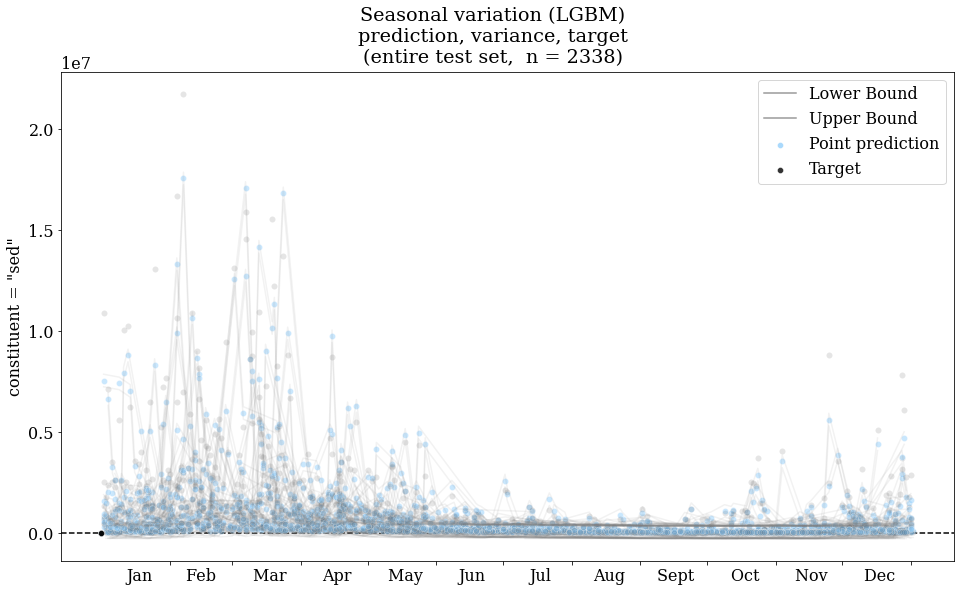

In [ ]:
for yr in df.index.year.unique():
  yr_data = [pd.Period(i, freq='D').dayofyear for i in df[df.index.year == yr].index]
  data = df[df.index.year == yr]
  a=sns.scatterplot(x=yr_data, y=df[df.index.year == yr]['lgbm'], color=colors['lgbm'], alpha=.5)#, label = 'Point prediction')
  b=sns.lineplot(x=yr_data, y=df[df.index.year == yr]['lgbm_l'], color='grey', alpha = .1)#, label = 'Lower bound')
  c=sns.lineplot(x=yr_data, y=df[df.index.year == yr]['lgbm_u'], color='grey', alpha = .10)#, label = 'Upper bound')
  d = sns.scatterplot(x=yr_data, y=df[df.index.year == yr]['target'], color='k', alpha = .1)#, label = "Target")#, label = "Target")
plt.axhline(y = 0, color ="black", linestyle ="--", zorder=0)
plt.suptitle("Seasonal variation (LGBM)\nprediction, variance, target\n(entire test set,  n = {})".format(len(df.index)))
plt.xticks([31,31+28,31+28+31,31+28+31+30,31+28+31+30+31,
            31+28+31+30+31+30,31+28+31+30+31+30+31,31+28+31+30+31+30+31+31,
            31+28+31+30+31+30+31+31+30,31+28+31+30+31+30+31+31+30+31,
            31+28+31+30+31+30+31+31+30+31+30,31+28+31+30+31+30+31+31+30+31+30+31],
           labels = [i+'            ' for i in months_])
t_a = sns.scatterplot(x=[0,0], y=[0,0], color=colors['lgbm'], alpha=.8, label = 'Point prediction')
t_b = sns.lineplot(x=[0,0], y=[0,0], color='grey', alpha=.8, label = 'Lower Bound')
t_c = sns.lineplot(x=[0,0], y=[0,0], color='grey', alpha=.8, label = 'Upper Bound')
t_a = sns.scatterplot(x=[0,0], y=[0,0], color='k', alpha=.8, label = 'Target')

#plt.legend()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.ylabel('constituent = "sed"')
plt.legend(by_label.values(), by_label.keys())
plt.show()

In [ ]:
!pip install properscoring
import properscoring as ps


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
for constit in constituents_:
  for d_s in data_sets:
    for m_s in models_sets:
      print(constit,'-',d_s,'-',m_s, ps.crps_ensemble(eval_dict[constit][d_s][m_s]['pred'], all_models[constit][d_s][m_s].y_te).mean())
    print()

print(df.info())
      

pn - van - xgbm 1344.8193821265259
pn - van - lgbm 1131.741553313981
pn - van - pgbm 1171.4292500933568

pn - ewm - xgbm 1277.5906151871245
pn - ewm - lgbm 1024.0466928952346
pn - ewm - pgbm 955.1160623681134

pn - rip - xgbm 871.25841546142
pn - rip - lgbm 702.1231035668649
pn - rip - pgbm 706.9401201156073

pp - van - xgbm 504.1742004611175
pp - van - lgbm 433.1873339356928
pp - van - pgbm 451.6569966121037

pp - ewm - xgbm 476.5084121745189
pp - ewm - lgbm 387.63169834487087
pp - ewm - pgbm 376.0999939157043

pp - rip - xgbm 336.97654430260843
pp - rip - lgbm 259.78267323189476
pp - rip - pgbm 274.1792114099859

sed - van - xgbm 176153.57552182276
sed - van - lgbm 147353.32569993965
sed - van - pgbm 152475.71699075983

sed - ewm - xgbm 167457.25493072593
sed - ewm - lgbm 130469.4406996077
sed - ewm - pgbm 129439.64296433215

sed - rip - xgbm 115228.14011775253
sed - rip - lgbm 90145.36560521054
sed - rip - pgbm 107315.52081815928

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex:

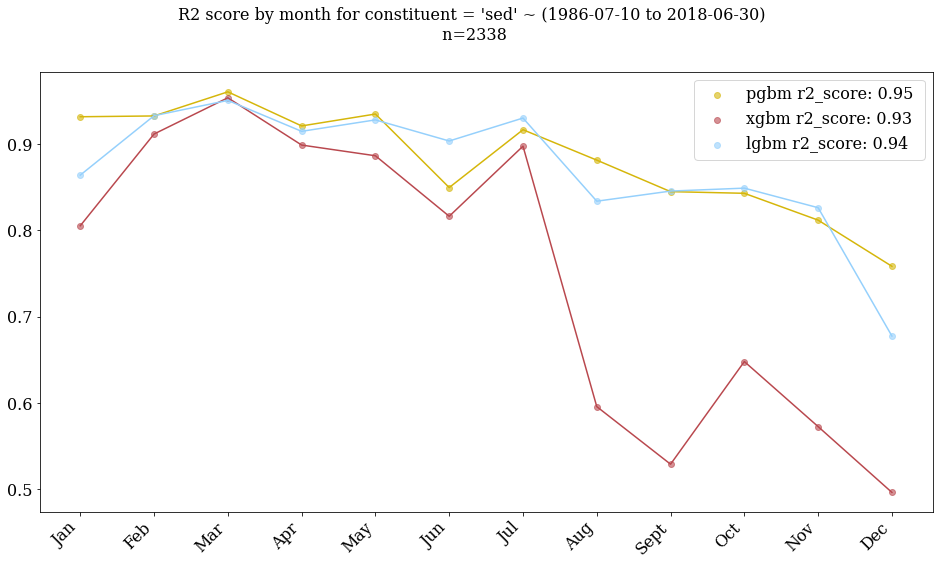

2338


In [ ]:
fig, ax = plt.subplots()
fig.suptitle("R2 score by month for constituent = '{}' ~ ({} to {})\n n={}".format(constit, str(df.index.min())[:10],
                                                                                          str(df.index.max())[:10],len(df) ), fontsize=16)
fig.autofmt_xdate(rotation=45)
labels = ['']
colors = {'lgbm': 'xkcd:Light Blue', 'pgbm': 'xkcd:Dark Yellow', 'xgbm': 'xkcd:Dusty Red'}
n =0
months_ = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
pos = np.array([200, 400, 600, 800])
months = ['blank', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
mons = [1,2,3,4,5,6,7,8,9,10,11, 12]
r2_pgbm = np.array([r2_score(df[df.index.month == i]['pgbm'], df[df.index.month == i]['target']) for i in mons ])
r2_all_pgbm = eval_dict['sed']['ewm']['pgbm']['r2_score']
r2_xgbm = np.array([r2_score(df[df.index.month == i]['xgbm'], df[df.index.month == i]['target']) for i in mons ])
r2_all_xgbm = eval_dict['sed']['ewm']['xgbm']['r2_score']
r2_lgbm = np.array([r2_score(df[df.index.month == i]['lgbm'], df[df.index.month == i]['target']) for i in mons ])
r2_all_lgbm = eval_dict['sed']['ewm']['lgbm']['r2_score']
plt.plot([i*5 for i in mons], 
         r2_pgbm,
         color = colors['pgbm'] )
plt.plot([i*5 for i in mons], 
         r2_xgbm,
         color = colors['xgbm'] )
plt.plot([i*5 for i in mons], 
         r2_lgbm,
         color = colors['lgbm'] )
for idx, i in enumerate([1,2,3,4,5,6,7,8,9,10,11, 12]):
  n += len(df[df.index.month == i]['target'])
  plt.scatter(i*5,
                               r2_score(df[df.index.month == i]['pgbm'], df[df.index.month == i]['target']),
                               color = colors['pgbm'], alpha = .6, label='pgbm r2_score: {:.2f} '.format(r2_all_pgbm))
  plt.scatter(i*5,
                               r2_score(df[df.index.month == i]['xgbm'], df[df.index.month == i]['target']),
                               color = colors['xgbm'], alpha = .6, label='xgbm r2_score: {:.2f} '.format(r2_all_xgbm))
  plt.scatter(i*5,
                               r2_score(df[df.index.month == i]['lgbm'], df[df.index.month == i]['target']),
                               color = colors['lgbm'], alpha = .6, label='lgbm r2_score: {:.2f} '.format(r2_all_lgbm))
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize =16)
plt.xticks([i*5 for i in [1,2,3,4,5,6,7,8,9,10,11, 12]], months_)
plt.show()
print(n)

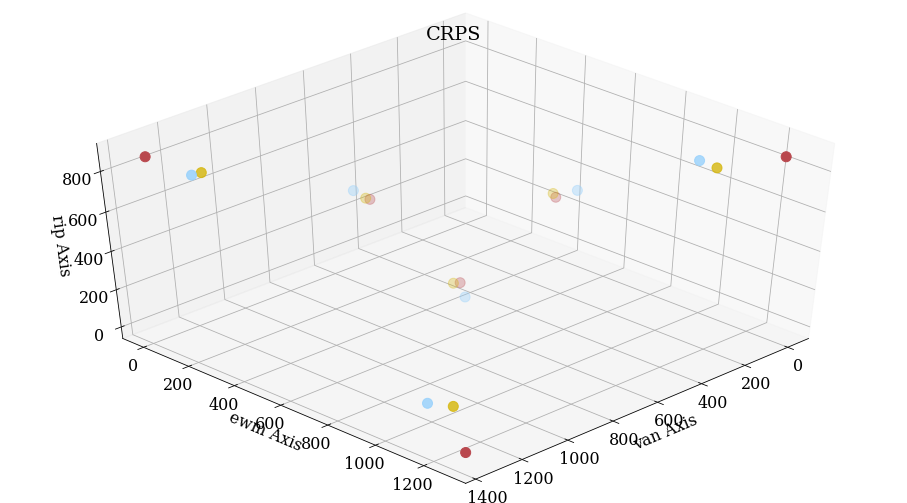

In [ ]:


# Plot
ax = plt.figure().add_subplot(projection='3d')
xs = [ps.crps_ensemble(eval_dict[constit]['van'][m_s]['pred'],
                       all_models[constit]['van'][m_s].y_te).mean() for m_s in models_sets for constit in ['pn','pp'] ]
ys = [ps.crps_ensemble(eval_dict[constit]['ewm'][m_s]['pred'],
                       all_models[constit]['ewm'][m_s].y_te).mean() for m_s in models_sets for constit in ['pn','pp']]
zs = [ps.crps_ensemble(eval_dict[constit]['rip'][m_s]['pred'],
                       all_models[constit]['rip'][m_s].y_te).mean() for m_s in models_sets for constit in ['pn','pp',]]

ax.scatter3D(xs,ys,np.zeros(len(zs)), c = [colors['xgbm'], colors['lgbm'], colors['pgbm'],
                            #colors['xgbm'], colors['lgbm'], colors['pgbm'],
                            colors['xgbm'], colors['lgbm'], colors['pgbm']],norm=normalize, s=100)
ax.scatter3D(xs,np.zeros(len(ys)),zs, c = [colors['xgbm'], colors['lgbm'], colors['pgbm'],
                            #colors['xgbm'], colors['lgbm'], colors['pgbm'],
                            colors['xgbm'], colors['lgbm'], colors['pgbm']], norm=normalize, s=100)
ax.scatter3D(np.zeros(len(xs)),ys,zs, c = [colors['xgbm'], colors['lgbm'], colors['pgbm'],
                            #colors['xgbm'], colors['lgbm'], colors['pgbm'],
                            colors['xgbm'], colors['lgbm'], colors['pgbm']], norm=normalize, s=100)

ax.set_xlabel("van Axis")
ax.set_ylabel("ewm Axis")
ax.set_zlabel("rip Axis")
ax.set_title("CRPS")
ax.view_init(45, 45)

plt.show()

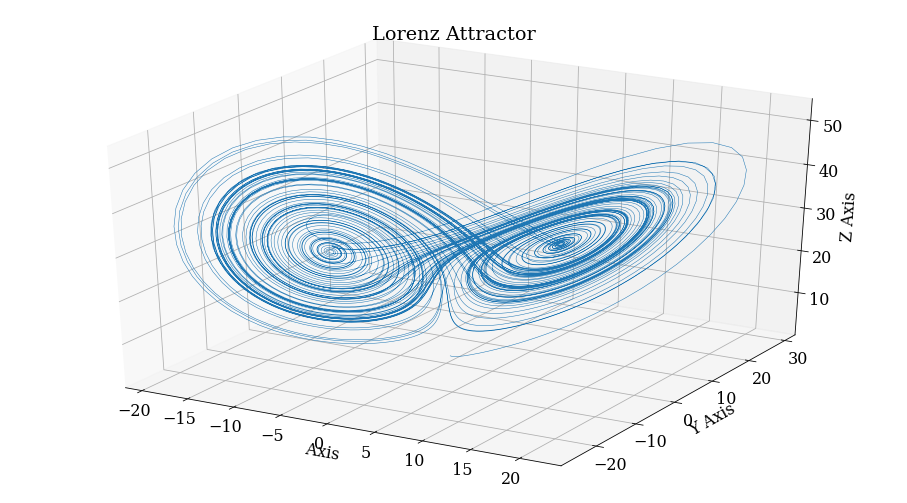

In [ ]:

def lorenz(xyz, *, s=10, r=28, b=2.667):
    """
    Parameters
    ----------
    xyz : array-like, shape (3,)
       Point of interest in three dimensional space.
    s, r, b : float
       Parameters defining the Lorenz attractor.

    Returns
    -------
    xyz_dot : array, shape (3,)
       Values of the Lorenz attractor's partial derivatives at *xyz*.
    """
    x, y, z = xyz
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])


dt = 0.01
num_steps = 10000

xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
xyzs[0] = (0., 1., 1.05)  # Set initial values
# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt

# Plot
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*xyzs.T, lw=0.5)
ax.set_xlabel(" Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

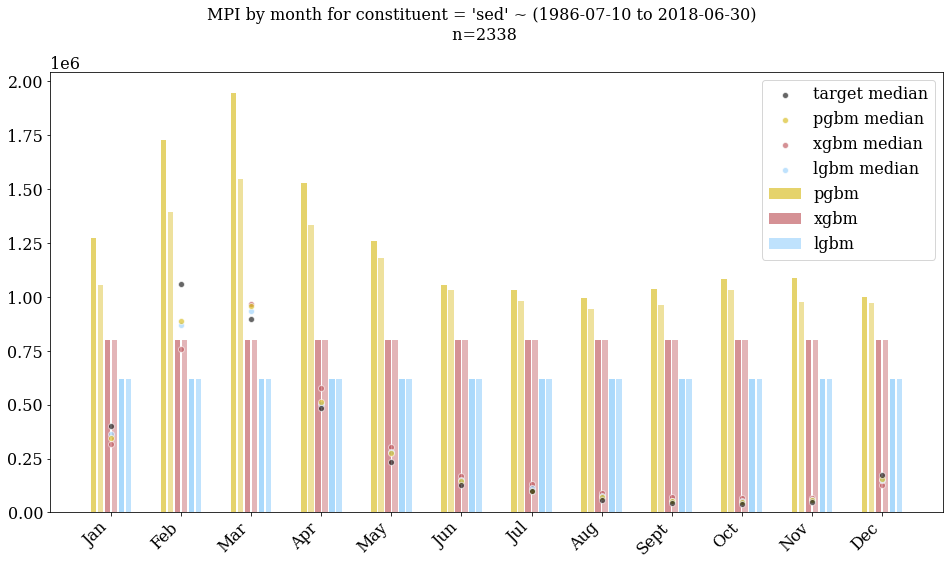

In [ ]:
fig, ax = plt.subplots()
fig.suptitle("MPI by month for constituent = '{}' ~ ({} to {})\n n={}".format(constit, str(df.index.min())[:10],
                                                                                          str(df.index.max())[:10],len(df) ), fontsize=16)
fig.autofmt_xdate(rotation=45)
labels = ['']
colors = {'lgbm': 'xkcd:Light Blue', 'pgbm': 'xkcd:Dark Yellow', 'xgbm': 'xkcd:Dusty Red'}

months_ = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
pos = np.array([200, 400, 600, 800])
months = ['blank', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
mons = [1,2,3,4,5,6,7,8,9,10,11, 12]
plt.bar([i*10-2.5 for i in mons], 
         [MPI(df[df.index.month == i]['pgbm_l'], df[df.index.month == i]['pgbm_u']) for i in mons ],
         color = colors['pgbm'], alpha = .6, label = 'pgbm' )
plt.bar([i*10-.5 for i in mons], 
         [MPI(df[df.index.month == i]['xgbm_l'], df[df.index.month == i]['xgbm_u']) for i in mons ],
         color = colors['xgbm'], alpha = .6,  label = 'xgbm')
plt.bar([i*10+1.5 for i in mons], 
         [MPI(df[df.index.month == i]['lgbm_l'], df[df.index.month == i]['lgbm_u']) for i in mons ],
         color = colors['lgbm'], alpha = .8 )
plt.bar([i*10-1.5 for i in mons], 
         [np.median(df[df.index.month == i]['pgbm_u']) - np.median(df[df.index.month == i]['pgbm_l'])  for i in mons ],
         color = colors['pgbm'], alpha = .4 )
plt.bar([i*10+.5 for i in mons], 
         [np.median(df[df.index.month == i]['xgbm_u']) - np.median(df[df.index.month == i]['xgbm_l'])  for i in mons ],
         color = colors['xgbm'], alpha = .4 )
plt.bar([i*10+2.5 for i in mons], 
         [np.median(df[df.index.month == i]['lgbm_u']) - np.median(df[df.index.month == i]['lgbm_l'])  for i in mons ],
         color = colors['lgbm'], alpha = .6, label = 'lgbm'  )
for idx, i in enumerate([1,2,3,4,5,6,7,8,9,10,11, 12]):  
  plt.scatter(i*10,
              np.median(df[df.index.month == i]['target']),
              color = 'k',
              edgecolors = 'white',
              label = 'target median',
              zorder = 1000,
              alpha = .6)
  plt.scatter(i*10,
              np.median(df[df.index.month == i]['pgbm']),
              color = colors['pgbm'],
              label = 'pgbm median',
              edgecolors = 'white',
              zorder = 900,
              alpha = .6)
  plt.scatter(i*10,
              np.median(df[df.index.month == i]['xgbm']),
              color = colors['xgbm'],
              label = 'xgbm median',
              edgecolors = 'white',
              zorder = 500,
              alpha = .6)
  plt.scatter(i*10,
              np.median(df[df.index.month == i]['lgbm']),
              color = colors['lgbm'],
              label = 'lgbm median',
              edgecolors = 'white',
              zorder = 500,
              alpha = .6)
  

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xticks([i*10 for i in [1,2,3,4,5,6,7,8,9,10,11, 12]], months_)
plt.show()

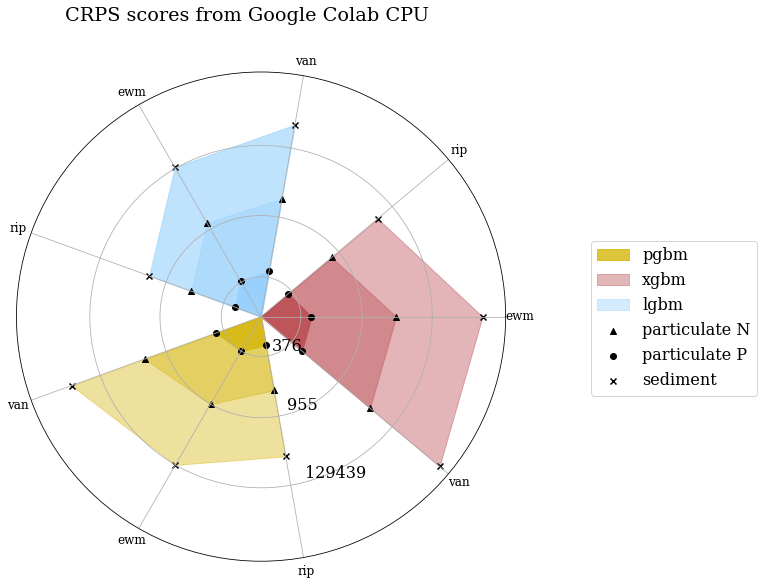

In [ ]:
colors = {'lgbm': 'xkcd:Light Blue', 'pgbm': 'xkcd:Dark Yellow', 'xgbm': 'xkcd:Dusty Red'}
plt.rcParams["figure.figsize"] = (16,9)

fig, ax = plt.subplots( subplot_kw={'projection': 'polar'})

ax = plt.subplot(111,polar=True)
ax.set_rlabel_position(-75)  # Move radial labels away from plotted line
rads = [i*360/9 for i in range(9)]

r = np.array([ps.crps_ensemble(eval_dict['pn'][d_s][m_s]['pred'], all_models['pn'][d_s][m_s].y_te).mean() for m_s in models_sets for d_s in data_sets])
r2 = np.array([ps.crps_ensemble(eval_dict['pp'][d_s][m_s]['pred'], all_models['pp'][d_s][m_s].y_te).mean() for m_s in models_sets for d_s in data_sets])
r3 = np.array([ps.crps_ensemble(eval_dict['sed'][d_s][m_s]['pred'], all_models['sed'][d_s][m_s].y_te).mean()/80 for m_s in models_sets for d_s in data_sets])
theta = [i*360/9 for i in range(len(r))]

r_min = r.min()
r2_min = r2.min()
r3_min = r3.min()
ax.set_thetagrids(rads, ['ewm','rip','van','ewm','rip','van','ewm','rip','van'], fontsize = 12)

ax.fill_between([-2*np.pi/9+2*i*np.pi/9 for i in range(3)],
    .75,        
    r3[:3],
    color = colors['xgbm'],
    alpha = .4)

ax.fill_between([-2*np.pi/9+2*i*np.pi/9 for i in range(3,6,1)],
    .75,        
    r3[3:6],
    color = colors['lgbm'],
    alpha = .6)

ax.fill_between([-2*np.pi/9+2*i*np.pi/9 for i in range(6,9,1)],
    .75,        
    r3[6:9],
    color = colors['pgbm'],
    alpha = .4)

ax.fill_between([-2*np.pi/9+2*i*np.pi/9 for i in range(3)],
    .75,        
    r2[:3],
    color = colors['xgbm'],
    alpha = .8)

ax.fill_between([-2*np.pi/9+2*i*np.pi/9 for i in range(3,6,1)],
    .75,        
    r2[3:6],
    color = colors['lgbm'],
    alpha = .8)

ax.fill_between([-2*np.pi/9+2*i*np.pi/9 for i in range(6,9,1)],
    .75,        
    r2[6:9],
    color = colors['pgbm'],
    label = 'pgbm',
    alpha = .8)

ax.fill_between([-2*np.pi/9+2*i*np.pi/9 for i in range(3)],
    .75,        
    r[:3],
    color = colors['xgbm'],
    label = 'xgbm',
    alpha = .4)

ax.fill_between([-2*np.pi/9+2*i*np.pi/9 for i in range(3,6,1)],
    .75,        
    r[3:6],
    color = colors['lgbm'],
    label = 'lgbm',
    alpha = .4)

ax.fill_between([-2*np.pi/9+2*i*np.pi/9 for i in range(6,9,1)],
    .75,        
    r[6:9],
    color = colors['pgbm'],
    alpha = .4)

ax.scatter([-2*np.pi/9+2*i*np.pi/9 for i in range(len(r))], r, c= ['k'], label = 'particulate N', marker='^')
ax.scatter([-2*np.pi/9+2*i*np.pi/9 for i in range(len(r2))], r2, c= ['k'], label = 'particulate P', marker = 'o')
ax.scatter([-2*np.pi/9+2*i*np.pi/9 for i in range(len(r3))], r3, c= ['k'], label = 'sediment', marker='x')

#ax.set_rmax(1.01)
#ax.set_rmin(.75)
 # Less radial ticks
ax.set_rgrids([ps.crps_ensemble(eval_dict['pp']['ewm']['pgbm']['pred'], all_models['pp']['ewm']['pgbm'].y_te).mean(),
               ps.crps_ensemble(eval_dict['pn']['ewm']['pgbm']['pred'], all_models['pn']['ewm']['pgbm'].y_te).mean(),
               ps.crps_ensemble(eval_dict['sed']['ewm']['pgbm']['pred'], all_models['sed']['ewm']['pgbm'].y_te).mean()/80],
              [int(ps.crps_ensemble(eval_dict['pp']['ewm']['pgbm']['pred'], all_models['pp']['ewm']['pgbm'].y_te).mean()),
               int(ps.crps_ensemble(eval_dict['pn']['ewm']['pgbm']['pred'], all_models['pn']['ewm']['pgbm'].y_te).mean()),
               int(ps.crps_ensemble(eval_dict['sed']['ewm']['pgbm']['pred'], all_models['sed']['ewm']['pgbm'].y_te).mean())])
#ax.set_rticklabels([376,955,1618*80])
plt.suptitle(                  'CRPS scores from Google Colab CPU')
plt.legend(bbox_to_anchor=(.95,0.5),loc="center right",fontsize=16, bbox_transform=plt.gcf().transFigure)
plt.show()

In [ ]:
import json

data = json.load(open(save_path +'/unopt_output/'+'unopt_eval_dict.json'))
opt_data = {}
opt_data_pgbm = json.load(open(save_path + '/optuna_output/' + 'optuna_pgbm_eval_dict.json' ))
opt_data_xgbm = json.load(open(save_path + '/optuna_output/' + 'optuna_xgbm_eval_dict.json' ))
opt_data_lgbm = json.load(open(save_path + '/optuna_output/' + 'optuna_lgbm_eval_dict.json' ))
opt_data['pgbm'] = opt_data_pgbm['pgbm']
opt_data['xgbm'] = opt_data_xgbm['xgbm']
opt_data['lgbm'] = opt_data_lgbm['lgbm']
print(opt_data.keys())
opt_data['lgbm']['rip'] = opt_data['xgbm']['rip'] #approximate missing data with xgbm data
models_sets = list(data.keys())
data_sets = list(data[models_sets[0]].keys())
constituents = ['din','don','dop','frp','pn', 'pp','sed']
colours = ['blank','red','yellow','blue','green','violet', 'orange','brown']

dict_keys(['pgbm', 'xgbm', 'lgbm'])


In [ ]:
print(eval_dict['din']['van']['xgbm'].keys())

print(eval_dict['din']['ewm']['lgbm'].keys())

print(eval_dict['din']['rip']['pgbm'].keys())

from collections import defaultdict

def tree(): return defaultdict(tree)


_eval_dict_ = tree()

for m_s in models_sets:
  for d_s in data_sets:
    for constit in constituents:
      for k in ['r2_score', 'PICP', 'MPI', 'CRPS']:
        if k == 'CRPS':
          _eval_dict_[m_s][d_s][constit]['CRPS'] = ps.crps_ensemble(eval_dict[constit][d_s][m_s]['pred'],
                                                                    all_models[constit][d_s][m_s].y_te).mean()
        else:
          _eval_dict_[m_s][d_s][constit][k] = eval_dict[constit][d_s][m_s][k]


print(_eval_dict_.keys())

dict_keys(['r2_score', 'PICP', 'MPI', 'NMPI', 'pred', 'pred_dist', 'CLC'])
dict_keys(['r2_score', 'PICP', 'MPI', 'NMPI', 'pred', 'pred_dist', 'CLC'])
dict_keys(['r2_score', 'PICP', 'MPI', 'NMPI', 'pred', 'pred_dist', 'CLC'])
dict_keys(['xgbm', 'lgbm', 'pgbm'])


In [ ]:
print(all_times)

{'din': {'din_van_xgbm': (23.769431114196777, (1668862356.4293883, 1668862369.1723225, 1668862380.1967506)), 'din_van_lgbm': (3.7282915115356445, (1668862380.1971872, 1668862382.4317906, 1668862383.924136)), 'din_van_pgbm': (89.83042311668396, (1668862383.9254715, 1668862459.9183836, 1668862473.172656)), 'din_ewm_xgbm': (17.30318570137024, (1668862473.7565322, 1668862483.6172142, 1668862491.0586777)), 'din_ewm_lgbm': (7.359150648117065, (1668862491.0591526, 1668862495.326161, 1668862498.4170332)), 'din_ewm_pgbm': (16.495570421218872, (1668862498.4189425, 1668862508.6818924, 1668862514.3323894)), 'din_rip_xgbm': (109.53637671470642, (1668862514.9144785, 1668862570.178889, 1668862624.4497514)), 'din_rip_lgbm': (53.21061563491821, (1668862624.450344, 1668862650.493896, 1668862677.6604047)), 'din_rip_pgbm': (75.96730065345764, (1668862677.6609364, 1668862737.0934803, 1668862752.7627487))}, 'don': {'don_van_xgbm': (9.351413488388062, (1668862770.319712, 1668862774.07486, 1668862779.6707218)

In [ ]:
from json import JSONEncoder
from pandas import Timestamp

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, Timestamp):
            return str(obj)
        return JSONEncoder.default(self, obj)
    pass
    
with open(save_path + 'model data/' + '{}_eval_dict.json'.format('cpu'), 'w') as f:
    json.dump(_eval_dict_, f, cls=NumpyArrayEncoder)
    print("saved eval scores")
    pass

with open(save_path + 'model data/' + '{}_times.json'.format('cpu'), 'w') as f:
    json.dump(all_times, f)
    print("saved times")


saved eval scores
saved times


In [ ]:
print(stop)
fig, ax = plt.subplots( subplot_kw={'projection': 'polar'})
plt.suptitle('         R2 score comparison\n tuned vs untuned models using local GPU')
ax = plt.subplot(111,polar=True)
ax.set_rlabel_position(-13)  # Move radial labels away from plotted line
rads = [i*360/21 for i in range(21)]
ax.set_thetagrids(rads, [i for j in range(3) for i in constituents  ], fontsize = 12)

r = np.array([[opt_data[m_s][d_s][constit]['r2_score'] for m_s in models_sets for constit in constituents] for d_s in data_sets])
r_ = np.array([[eval_dict[constit][d_s][m_s]['r2_score'] for m_s in models_sets for constit in constituents] for d_s in data_sets])
xgbm_max = [np.array((r[0][i],r[1][i],r[2][i])).max() for i in range(7)]

lgbm_max = [np.array((r[0][i],r[1][i],r[2][i])).max() for i in range(7, 14, 1)]

pgbm_max = [np.array((r[0][i],r[1][i],r[2][i])).max() for i in range(14, 21, 1)]

#print(pgbm_max, xgbm_max, lgbm_max)

test_r = np.array([['{}_{}_{}_{}'.format(d_s, m_s, constit, data[m_s][d_s][constit]['r2_score']) for m_s in models_sets for constit in constituents] for d_s in data_sets])
#print(test_r)

#xgbm
ax.fill_between([2*i*np.pi/21 for i in range(0,7,1)],
    .75,        
    xgbm_max,
    label = 'xgbm',
    color = colors['xgbm'],
    alpha = .4)
#lgbm
ax.fill_between([2*i*np.pi/21 for i in range(7,14,1)],
    .75,        
    lgbm_max,
    label = 'lgbm',
    color = colors['lgbm'],
    alpha = .4)
#pgbm
ax.fill_between([2*i*np.pi/21 for i in range(14,21,1)],
    .75,        
    pgbm_max,
    label = 'pgbm',
    color = colors['pgbm'],
    alpha = .4)

#van
ax.plot([2*i*np.pi/21 for i in range(7)], r[0][:7], c= '#222222', label = 'optuna van', marker='^', lw=.5)
ax.plot([2*i*np.pi/21 for i in range(7,14)], r[0][7:14], c= '#222222', label = 'optuna van', marker='^', lw=.5)
ax.plot([2*i*np.pi/21 for i in range(14,21)], r[0][14:], c= '#222222', label = 'optuna van', marker='^', lw=.5)
#ewm
ax.plot([2*i*np.pi/21 for i in range(7)], r[1][:7], c= '#222222', label = 'optuna ewm', marker='o', lw=.5)
ax.plot([2*i*np.pi/21 for i in range(7,14)], r[1][7:14], c= '#222222', label = 'optuna ewm', marker='o', lw=.5)
ax.plot([2*i*np.pi/21 for i in range(14,21)], r[1][14:], c= '#222222', label = 'optuna ewm', marker='o', lw=.5)
#rip
ax.plot([2*i*np.pi/21 for i in range(7)], r[2][:7], c= '#222222', label = 'optuna rip', marker='x', lw=.5)
ax.plot([2*i*np.pi/21 for i in range(7,14)], r[2][7:14], c= '#222222', label = 'optuna rip', marker='x', lw=.5)
ax.plot([2*i*np.pi/21 for i in range(14,21)], r[2][14:], c= '#222222', label = 'optuna rip', marker='x', lw=.5)

#unopt van
ax.scatter([2*i*np.pi/21 for i in range(7)], r_[0][:7], c= '#aa4444', label = 'unopt van', marker='^')
ax.scatter([2*i*np.pi/21 for i in range(7,14)], r_[0][7:14], c= '#aa4444', label = 'unopt van', marker='^')
ax.scatter([2*i*np.pi/21 for i in range(14,21)], r_[0][14:], c= '#aa4444', label = 'unopt van', marker='^')
#unopt ewm
ax.scatter([2*i*np.pi/21 for i in range(7)], r_[1][:7], c= '#aa4444', label = 'unopt ewm', marker='o')
ax.scatter([2*i*np.pi/21 for i in range(7,14)], r_[1][7:14], c= '#aa4444', label = 'unopt ewm', marker='o')
ax.scatter([2*i*np.pi/21 for i in range(14,21)], r_[1][14:], c= '#aa4444', label = 'unopt ewm', marker='o')
#unopt rip
ax.scatter([2*i*np.pi/21 for i in range(7)], r_[2][:7], c= '#aa4444', label = 'unopt rip', marker='x')
ax.scatter([2*i*np.pi/21 for i in range(7,14)], r_[2][7:14], c= '#aa4444', label = 'unopt rip', marker='x')
ax.scatter([2*i*np.pi/21 for i in range(14,21)], r_[2][14:], c= '#aa4444', label = 'unopt rip', marker='x')



#plt.legend()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(.9,0.5),loc="center right",fontsize=12, bbox_transform=plt.gcf().transFigure)
ax.set_rmax(1.0)
ax.set_rmin(.75)
ax.tick_params(labelsize =12)
ax.set_rticks([0.85, .9, .95, .99])  # Less radial ticks
plt.show()


In [ ]:

gpu_time_dict = json.load(open(save_path +'/unopt_output/'+'unopt_times.json'))
print(gpu_time_dict)

In [ ]:
tot_times = {'pgbm': 0,
             'xgbm': 0,
             'lgbm': 0}
gpu_times = {'pgbm': 0,
             'xgbm': 0,
             'lgbm': 0}
for m_s in models_sets:
  for d_s in data_sets:
    for constit in constituents:
      tot_times[m_s] += all_times[constit]['{}_{}_{}'.format(constit, d_s, m_s)][0]
      gpu_times[m_s] += gpu_time_dict[m_s][d_s][constit][3] - gpu_time_dict[m_s][d_s][constit][0]

print(tot_times)
print(gpu_times)

In [ ]:
from termcolor import colored


fig, ax = plt.subplots(figsize=(16,9), subplot_kw={'projection': 'polar'})
plt.suptitle('                    R2 score comparison CPU vs GPU')
ax = plt.subplot(111,polar=True)
ax.set_rlabel_position(-13)  # Move radial labels away from plotted line
rads = [i*360/21 for i in range(21)]
ax.set_thetagrids(rads, [i for j in range(3) for i in constituents  ], fontsize = 12)

r = np.array([[data[m_s][d_s][constit]['r2_score'] for m_s in models_sets for constit in constituents] for d_s in data_sets])
r_ = np.array([[eval_dict[constit][d_s][m_s]['r2_score'] for m_s in models_sets for constit in constituents] for d_s in data_sets])

#unopt_times = np.array([[all_times[constit][d_s][m_s] for m_s in models_sets for constit in constituents] for d_s in data_sets])

xgbm_max = [np.array((r[0][i],r[1][i],r[2][i])).max() for i in range(7)]

lgbm_max = [np.array((r[0][i],r[1][i],r[2][i])).max() for i in range(7, 14, 1)]

pgbm_max = [np.array((r[0][i],r[1][i],r[2][i])).max() for i in range(14, 21, 1)]

#print(pgbm_max, xgbm_max, lgbm_max)

test_r = np.array([['{}_{}_{}_{}'.format(d_s, m_s, constit, data[m_s][d_s][constit]['r2_score']) for m_s in models_sets for constit in constituents] for d_s in data_sets])
#print(test_r)
optuna_van_label = 'optuna van, ave time: {:.2f}'.format(1.23)
optuna_ewm_label = 'optuna ewm, ave time: {:.2f}'.format(1.23)
optuna_rip_label = 'optuna rip, ave time: {:.2f}'.format(1.23)

unopt_van_label = 'optuna van, ave time: {:.2f}'.format(1.23)
unopt_ewm_label = 'optuna ewm, ave time: {:.2f}'.format(1.23)
unopt_rip_label = 'optuna rip, ave time: {:.2f}'.format(1.23)

#xgbm
ax.fill_between([2*i*np.pi/21 for i in range(0,7,1)],
    .75,        
    xgbm_max,
    label = 'xgbm ',
    color = colors['xgbm'],
    alpha = .4)
#lgbm
ax.fill_between([2*i*np.pi/21 for i in range(7,14,1)],
    .75,        
    lgbm_max,
    label = 'lgbm ',
    color = colors['lgbm'],
    alpha = .4)
#pgbm
ax.fill_between([2*i*np.pi/21 for i in range(14,21,1)],
    .75,        
    pgbm_max,
    label = 'pgbm ',
    color = colors['pgbm'],
    alpha = .4)

#van
ax.plot([2*i*np.pi/21 for i in range(7)], r[0][:7], c= '#222222', label = 'gpu van', marker='^', lw=.5)
ax.plot([2*i*np.pi/21 for i in range(7,14)], r[0][7:14], c= '#222222', label = 'gpu van', marker='^', lw=.5)
ax.plot([2*i*np.pi/21 for i in range(14,21)], r[0][14:], c= '#222222', label = 'gpu van', marker='^', lw=.5)
#ewm
ax.plot([2*i*np.pi/21 for i in range(7)], r[1][:7], c= '#222222', label = 'gpu ewm', marker='o', lw=.5)
ax.plot([2*i*np.pi/21 for i in range(7,14)], r[1][7:14], c= '#222222', label = 'gpu ewm', marker='o', lw=.5)
ax.plot([2*i*np.pi/21 for i in range(14,21)], r[1][14:], c= '#222222', label = 'gpu ewm', marker='o', lw=.5)
#rip
ax.plot([2*i*np.pi/21 for i in range(7)], r[2][:7], c= '#222222', label = 'gpu rip', marker='x', lw=.5)
ax.plot([2*i*np.pi/21 for i in range(7,14)], r[2][7:14], c= '#222222', label = 'gpu rip', marker='x', lw=.5)
ax.plot([2*i*np.pi/21 for i in range(14,21)], r[2][14:], c= '#222222', label = 'gpu rip', marker='x', lw=.5)

#unopt van
ax.scatter([2*i*np.pi/21 for i in range(7)], r_[0][:7], c= '#aa4444', label = 'cpu van', marker='^')
ax.scatter([2*i*np.pi/21 for i in range(7,14)], r_[0][7:14], c= '#aa4444', label = 'cpu van', marker='^')
ax.scatter([2*i*np.pi/21 for i in range(14,21)], r_[0][14:], c= '#aa4444', label = 'cpu van', marker='^')
#cpu ewm
ax.scatter([2*i*np.pi/21 for i in range(7)], r_[1][:7], c= '#aa4444', label = 'cpu ewm', marker='o')
ax.scatter([2*i*np.pi/21 for i in range(7,14)], r_[1][7:14], c= '#aa4444', label = 'cpu ewm', marker='o')
ax.scatter([2*i*np.pi/21 for i in range(14,21)], r_[1][14:], c= '#aa4444', label = 'cpu ewm', marker='o')
#cpu rip
ax.scatter([2*i*np.pi/21 for i in range(7)], r_[2][:7], c= '#aa4444', label = 'cpu rip', marker='x')
ax.scatter([2*i*np.pi/21 for i in range(7,14)], r_[2][7:14], c= '#aa4444', label = 'cpu rip', marker='x')
ax.scatter([2*i*np.pi/21 for i in range(14,21)], r_[2][14:], c= '#aa4444', label = 'cpu rip', marker='x')



#plt.legend()
handles, labels = plt.gca().get_legend_handles_labels()
print(labels)
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(.9,0.5),loc="center right",fontsize=12, bbox_transform=plt.gcf().transFigure)
ax.set_rmax(1.0)
ax.set_rmin(.75)
ax.tick_params(labelsize =12)
ax.set_rticks([0.85, .9, .95, .99])  # Less radial ticks
plt.show()

In [ ]:
time_dict = {}
time_dict['pgbm'] = json.load(open(save_path +'/optuna_output/'+'optuna_pgbm_times.json'))
time_dict['xgbm'] = json.load(open(save_path +'/optuna_output/'+'optuna_xgbm_times.json'))
time_dict['lgbm'] = json.load(open(save_path +'/optuna_output/'+'optuna_lgbm_times.json'))
time_dict['lgbm']['lgbm']['rip'] = time_dict['xgbm']['xgbm']['rip']
print(time_dict)

In [ ]:
fig, ax = plt.subplots(figsize=(16,9), subplot_kw={'projection': 'polar'})
plt.suptitle('                    Hyperparameter tuning times for models')
ax = plt.subplot(111,polar=True)
ax.set_rlabel_position(-13)  # Move radial labels away from plotted line
rads = [i*360/21 for i in range(21)]
ax.set_thetagrids(rads, [i for j in range(3) for i in constituents  ], fontsize = 12)

#r_ = np.array([[all_times[constit]['{}_{}_{}'.format(constit, d_s, m_s)][0]/5 if d_s == 'rip' else all_times[constit]['{}_{}_{}'.format(constit, d_s, m_s)][0] for m_s in models_sets for constit in constituents ] for d_s in data_sets])

r = np.array([[time_dict[m_s][m_s][d_s][constit][1] - time_dict[m_s][m_s][d_s][constit][0] for m_s in models_sets for constit in constituents ] for d_s in ['ewm','van']])

xgbm_max = [np.array((r[0][i],r[1][i])).max() for i in range(7)]

lgbm_max = [np.array((r[0][i],r[1][i])).max() for i in range(7, 14, 1)]

pgbm_max = [np.array((r[0][i],r[1][i])).max() for i in range(14, 21, 1)]

#print(pgbm_max, xgbm_max, lgbm_max)

test_r = np.array([['{}_{}_{}_{}'.format(d_s, m_s, constit, data[m_s][d_s][constit]['r2_score']) for m_s in models_sets for constit in constituents] for d_s in data_sets])
#print(test_r)
optuna_van_label = 'optuna van, ave time: {:.2f}'.format(1.23)
optuna_ewm_label = 'optuna ewm, ave time: {:.2f}'.format(1.23)
optuna_rip_label = 'optuna rip, ave time: {:.2f}'.format(1.23)

unopt_van_label = 'optuna van, ave time: {:.2f}'.format(1.23)
unopt_ewm_label = 'optuna ewm, ave time: {:.2f}'.format(1.23)
unopt_rip_label = 'optuna rip, ave time: {:.2f}'.format(1.23)

#xgbm
ax.fill_between([2*i*np.pi/21 for i in range(0,7,1)],
    .75,        
    xgbm_max,
    label = 'xgbm : {:.2f}s'.format(time_dict['lgbm']['total run time:']),
    color = colors['xgbm'],
    alpha = .4)
#lgbm
ax.fill_between([2*i*np.pi/21 for i in range(7,14,1)],
    .75,        
    lgbm_max,
    label = 'lgbm : {:.2f}s'.format(time_dict['xgbm']['total run time:']),
    color = colors['lgbm'],
    alpha = .4)
#pgbm
ax.fill_between([2*i*np.pi/21 for i in range(14,21,1)],
    .75,        
    pgbm_max,
    label = 'pgbm : {:.2f}s'.format(time_dict['pgbm']['total run time:']),
    color = colors['pgbm'],
    alpha = .4)

#van
ax.plot([2*i*np.pi/21 for i in range(7)], r[0][:7], c= 'b', label = 'gpu van', marker='^', lw=.5)
ax.plot([2*i*np.pi/21 for i in range(7,14)], r[0][7:14], c= 'b', label = 'gpu van', marker='^', lw=.5)
ax.plot([2*i*np.pi/21 for i in range(14,21)], r[0][14:], c= 'b', label = 'gpu van', marker='^', lw=.5)
#ewm
ax.plot([2*i*np.pi/21 for i in range(7)], r[1][:7], c= 'b', label = 'gpu ewm', marker='o', lw=.5)
ax.plot([2*i*np.pi/21 for i in range(7,14)], r[1][7:14], c= 'b', label = 'gpu ewm', marker='o', lw=.5)
ax.plot([2*i*np.pi/21 for i in range(14,21)], r[1][14:], c= 'b', label = 'gpu ewm', marker='o', lw=.5)



#plt.legend()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(.9,0.5),loc="center right",fontsize=12, bbox_transform=plt.gcf().transFigure)
ax.set_rmax(500)
ax.set_rmin(.75)
ax.tick_params(labelsize =12)
#ax.set_rticks([0.85, .9, .95, .99])  # Less radial ticks
plt.show()

In [ ]:
time_dict = {}
time_dict['pgbm'] = json.load(open(save_path +'/optuna_output/'+'optuna_pgbm_times.json'))
time_dict['xgbm'] = json.load(open(save_path +'/optuna_output/'+'optuna_xgbm_times.json'))
time_dict['lgbm'] = json.load(open(save_path +'/optuna_output/'+'optuna_lgbm_times.json'))
time_dict['lgbm']['lgbm']['rip'] = time_dict['xgbm']['xgbm']['rip']
print(time_dict)

In [ ]:
print([time_dict[m_s][m_s]['van'][constit] for m_s in models_sets for constit in constituents ])
print([time_dict[m_s][m_s]['van'][constit][3] - time_dict[m_s][m_s]['van'][constit][0] for m_s in models_sets for constit in constituents ])

In [ ]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots()
fig.suptitle("Hyperparameter tuning times for Optuna on local GPU")
ax.set_ylabel('time taken (s)')

colors = {'lgbm': 'xkcd:Light Blue', 'pgbm': 'xkcd:Dark Yellow', 'xgbm': 'xkcd:Dusty Red'}

months_ = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
pos = np.array([200, 400, 600, 800])
months = ['blank', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
mons = [1,2,3,4,5,6,7,8,9,10,11,12, 13, 14, 15, 16, 17, 18, 19,20,21]
for idx, d_s in enumerate(['van','ewm']):
  #print(idx, d_s)
  for jds, m_s in enumerate(models_sets):
    #print('      ', jds, m_s)
    bottom = 0
    for kdx, constit in enumerate(constituents):
      #print('            ', constit)
      ax.bar([10*(jds+1)+ 40*idx],
             [time_dict[m_s][m_s][d_s][constit][3] - time_dict[m_s][m_s][d_s][constit][0]],
             width = 8,
             color = colors[m_s],
             edgecolor = "black",
             alpha = 0.3 + .1*kdx,
             bottom = bottom)
      bottom += time_dict[m_s][m_s][d_s][constit][3] - time_dict[m_s][m_s][d_s][constit][0]
      ax.bar([0],
             [0],
             width = 0,
             label = constit,
             color = 'grey',
             edgecolor = "black",
             alpha = 0.3 + .1*kdx)
      
model_handles = [Line2D([0], [0], color=colors['xgbm'], lw=4),
                Line2D([0], [0], color=colors['lgbm'], lw=4),
                Line2D([0], [0], color=colors['pgbm'], lw=4)
                 ]
second_legend = plt.legend(handles = model_handles, labels = ['xgbm', 'lgbm', 'pgbm'], fontsize = 16, bbox_to_anchor=(.25,1),)
plt.gca().add_artist(second_legend)

handles, labels = plt.gca().get_legend_handles_labels()
#handles[-1].Patch.set_facecolor('black')
by_label = dict(zip(labels, handles))
plt.legend(reversed(list(by_label.values())), reversed(list(by_label.keys())), )
plt.tick_params(axis = 'x', labelsize = 18)
plt.xticks([20, 60], ['van','ewm'])
plt.show()      

#plt.legend()
plt.show()

In [ ]:
import json

colors = {'lgbm': list(reversed(['#7bc8f644', '#7bc8f688', '#7bc8f6dd'])),
          'xgbm': list(reversed(['#b9484e44', '#b9484e88', '#b9484edd'])),
          'pgbm': list(reversed(['#d5b60a66','#d5b60aaa', '#d5b60add']))}

fig, ax = plt.subplots( subplot_kw={'projection': 'polar'})



ax = plt.subplot(111,polar=True)
ax.set_thetagrids([0, 69, 33*np.pi, 69 + 33*np.pi, 65*np.pi, 69 + 65*np.pi], ['pn', 'pn','pp', 'pp','sed', 'sed'], fontsize = 12)
ax.set_rlabel_position(-45)  # Move radial labels away from plotted line
theta = [i*np.pi/21 for i in range(21)]
theta_ = [i*np.pi/21+np.pi for i in range(21)]


plt.suptitle('             CRPS tuned hyperparameter vs default hyperparameter models\n          constituents ("van", "ewm", "rip")')
#r = np.array([[data[m_s][d_s][constit]['CRPS'] for d_s in data_sets for constit in constituents] for m_s in models_sets])
r = np.array([[data[m_s][d_s][constit]['CRPS'] for m_s in models_sets for d_s in data_sets] for constit in constituents])

norm_r = []
for arra in r:
  norm = np.linalg.norm(arra)
  norm_data = arra/norm
  norm_r.append(norm_data)

test_r = [['{}_{}_{}_{}'.format(d_s, m_s, constit, data[m_s][d_s][constit]['CRPS']) for m_s in models_sets for d_s in data_sets] for constit in constituents]

#din
ax.bar(theta[:3], norm_r[4][:3], width = np.pi/21, color = colors['xgbm'], label = 'opt xgbm')
ax.bar(theta[3:6], norm_r[4][3:6], width = np.pi/21, color = colors['lgbm'], label = 'opt lgbm')
ax.bar(theta[6:9], norm_r[4][6:9], width = np.pi/21, color = colors['pgbm'], label = 'opt pgbm')
#don
ax.bar(theta[12:15], norm_r[5][:3], width = np.pi/21, color = colors['xgbm'])
ax.bar(theta[15:18], norm_r[5][3:6], width = np.pi/21, color = colors['lgbm'])
ax.bar(theta[18:21], norm_r[5][6:9], width = np.pi/21, color = colors['pgbm'])

ax.bar(theta_[3:6], norm_r[6][:3], width = np.pi/21, color = colors['xgbm'])
ax.bar(theta_[6:9], norm_r[6][3:6], width = np.pi/21, color = colors['lgbm'])
ax.bar(theta_[9:12], norm_r[6][6:9], width = np.pi/21, color = colors['pgbm'])

r_ = np.array([[opt_data[m_s][d_s][constit]['CRPS'] for m_s in models_sets for d_s in data_sets ] for constit in constituents])
norm_r_ = []
for arra in r_:
  norm = np.linalg.norm(arra)
  norm_data = arra/norm
  norm_r_.append(norm_data)

test_r = [['{}_{}_{}_{}'.format(d_s, m_s, constit, data[m_s][d_s][constit]['CRPS']) for m_s in models_sets for d_s in data_sets] for constit in constituents]


ax.bar(theta[:3], np.zeros_like(norm_r_[4][:3]), width = np.pi/21, bottom = norm_r_[4][:3],  color = colors['xgbm'], edgecolor = 'k', linewidth = 2, alpha = .3, zorder = 10000, label = 'unopt xgbm')
ax.bar(theta[3:6], np.zeros_like(norm_r_[4][:3]), width = np.pi/21, bottom = norm_r_[4][3:6], color = colors['lgbm'], edgecolor = 'k', linewidth = 2, alpha = .3, zorder = 10000,label = 'unopt lgbm')
ax.bar(theta[6:9], np.zeros_like(norm_r_[4][:3]),  width = np.pi/21, bottom = norm_r_[4][6:9], color = colors['pgbm'], edgecolor = 'k', linewidth = 2, alpha = .3, zorder = 10000,label = 'unopt pgbm')

ax.bar(theta[12:15], np.zeros_like(norm_r_[4][:3]), width = np.pi/21, bottom = norm_r_[5][:3], color = colors['xgbm'], edgecolor = 'k', linewidth = 2, alpha = .3, zorder = 10000)
ax.bar(theta[15:18], np.zeros_like(norm_r_[4][:3]), width = np.pi/21,  bottom = norm_r_[5][3:6], color = colors['lgbm'], edgecolor = 'k', linewidth = 2, alpha = .3, zorder = 10000)
ax.bar(theta[18:21], np.zeros_like(norm_r_[4][:3]), width = np.pi/21,  bottom = norm_r_[5][6:9], color = colors['pgbm'], edgecolor = 'k', linewidth = 2, alpha = .3, zorder = 10000)

ax.bar(theta_[3:6], np.zeros_like(norm_r_[4][:3]), width = np.pi/21, bottom = norm_r_[6][:3], color = colors['xgbm'], edgecolor = 'k', linewidth = 2, alpha = .3, zorder = 10000)
ax.bar(theta_[6:9], np.zeros_like(norm_r_[4][:3]), width = np.pi/21, bottom = norm_r_[6][3:6], color = colors['lgbm'], edgecolor = 'k', linewidth = 2, alpha = .3, zorder = 10000)
ax.bar(theta_[9:12], np.zeros_like(norm_r_[4][:3]), width = np.pi/21, bottom = norm_r_[6][6:9], color = colors['pgbm'], edgecolor = 'k', linewidth = 2, alpha = .3, zorder = 10000)

model_handles = [Line2D([0], [0], color='#77777766', lw=10),
                Line2D([0], [0], color='#777777aa', lw=10),
                Line2D([0], [0], color='#777777ee', lw=10)
]
second_legend = plt.legend(handles = model_handles, labels = ['rip', 'ewm', 'van'], fontsize = 12, bbox_to_anchor=(.9,.7),  bbox_transform=plt.gcf().transFigure)
plt.gca().add_artist(second_legend)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(.9,0.5),loc="center right",fontsize=12, bbox_transform=plt.gcf().transFigure)
ax.set_rgrids([0, 0.25, .5], [0, 0.5, 1])
plt.show()

In [ ]:
import json

colors = {'lgbm': list(reversed(['#7bc8f644', '#7bc8f688', '#7bc8f6dd'])),
          'xgbm': list(reversed(['#b9484e44', '#b9484e88', '#b9484edd'])),
          'pgbm': list(reversed(['#d5b60a66','#d5b60aaa', '#d5b60add']))}

colors_ = {'lgbm': list(reversed(['#ffffffff', '#ffffffff', '#ffffffff'])),
          'xgbm': list(reversed(['#ffffffff', '#ffffffff', '#ffffffff'])),
          'pgbm': list(reversed(['#ffffffff','#ffffffff', '#ffffffff']))}

fig, ax = plt.subplots( subplot_kw={'projection': 'polar'})



ax = plt.subplot(111,polar=True)
ax.set_thetagrids([0, 69, 33*np.pi, 69 + 33*np.pi, 65*np.pi, 69 + 65*np.pi], ['pn', 'pn','pp', 'pp','sed', 'sed'], fontsize = 12)
ax.set_rlabel_position(-45)  # Move radial labels away from plotted line
theta = [i*np.pi/21 for i in range(21)]
theta_ = [i*np.pi/21+np.pi for i in range(21)]



plt.suptitle('CRPS GPU vs CPU models\n constituents ("van", "ewm", "rip")')

#r = np.array([[data[m_s][d_s][constit]['CRPS'] for m_s in models_sets for d_s in data_sets] for constit in constituents])
r = np.array([[opt_data[m_s][d_s][constit]['CRPS'] for m_s in models_sets for d_s in data_sets] for constit in constituents ])
r_ = np.array([[ps.crps_ensemble(eval_dict[constit][d_s][m_s]['pred'], all_models[constit][d_s][m_s].y_te).mean() for m_s in models_sets for d_s in data_sets] for constit in constituents])
norm_r = []
for arra in r:
  norm = np.linalg.norm(arra)
  norm_data = arra/norm
  norm_r.append(norm_data)

test_r = [['{}_{}_{}_{}'.format(d_s, m_s, constit, data[m_s][d_s][constit]['CRPS']) for m_s in models_sets for d_s in data_sets] for constit in constituents]

#din
ax.bar(theta[:3], norm_r[4][:3], width = np.pi/21, color = colors['xgbm'], label = 'gpu xgbm')
ax.bar(theta[3:6], norm_r[4][3:6], width = np.pi/21, color = colors['lgbm'], label = 'gpu lgbm')
ax.bar(theta[6:9], norm_r[4][6:9], width = np.pi/21, color = colors['pgbm'], label = 'gpu pgbm')
#don
ax.bar(theta[12:15], norm_r[5][:3], width = np.pi/21, color = colors['xgbm'])
ax.bar(theta[15:18], norm_r[5][3:6], width = np.pi/21, color = colors['lgbm'])
ax.bar(theta[18:21], norm_r[5][6:9], width = np.pi/21, color = colors['pgbm'])

ax.bar(theta_[3:6], norm_r[6][:3], width = np.pi/21, color = colors['xgbm'])
ax.bar(theta_[6:9], norm_r[6][3:6], width = np.pi/21, color = colors['lgbm'])
ax.bar(theta_[9:12], norm_r[6][6:9], width = np.pi/21, color = colors['pgbm'])

#r_ = np.array([[opt_data[m_s][d_s][constit]['CRPS'] for m_s in models_sets for d_s in data_sets ] for constit in constituents])
norm_r_ = []
for arra in r_:
  norm = np.linalg.norm(arra)
  norm_data = arra/norm
  norm_r_.append(norm_data)

test_r = [['{}_{}_{}_{}'.format(d_s, m_s, constit, data[m_s][d_s][constit]['CRPS']) for m_s in models_sets for d_s in data_sets] for constit in constituents]


ax.bar(theta[:3], norm_r_[4][:3], width = np.pi/21, color = colors_['xgbm'], edgecolor = 'k', alpha = .3, zorder = 10000, label = 'cpu models')
ax.bar(theta[3:6], norm_r_[4][3:6], width = np.pi/21, color = colors_['lgbm'], edgecolor = 'k', alpha = .3, zorder = 10000)
ax.bar(theta[6:9], norm_r_[4][6:9], width = np.pi/21, color = colors_['pgbm'], edgecolor = 'k', alpha = .3, zorder = 10000)

ax.bar(theta[12:15], norm_r_[5][:3], width = np.pi/21, color = colors_['xgbm'], edgecolor = 'k', alpha = .3, zorder = 10000)
ax.bar(theta[15:18], norm_r_[5][3:6], width = np.pi/21, color = colors_['lgbm'], edgecolor = 'k', alpha = .3, zorder = 10000)
ax.bar(theta[18:21], norm_r_[5][6:9], width = np.pi/21, color = colors_['pgbm'], edgecolor = 'k', alpha = .3, zorder = 10000)

ax.bar(theta_[3:6], norm_r_[6][:3], width = np.pi/21, color = colors_['xgbm'], edgecolor = 'k', alpha = .3, zorder = 10000)
ax.bar(theta_[6:9], norm_r_[6][3:6], width = np.pi/21, color = colors_['lgbm'], edgecolor = 'k', alpha = .3, zorder = 10000)
ax.bar(theta_[9:12], norm_r_[6][6:9], width = np.pi/21, color = colors_['pgbm'], edgecolor = 'k', alpha = .3, zorder = 10000)

model_handles = [Line2D([0], [0], color='#77777766', lw=8),
                Line2D([0], [0], color='#777777aa', lw=8),
                Line2D([0], [0], color='#777777ee', lw=8)
]
second_legend = plt.legend(handles = model_handles, labels = ['rip', 'ewm', 'van'], fontsize = 12, bbox_to_anchor=(.9,.7),  bbox_transform=plt.gcf().transFigure)
plt.gca().add_artist(second_legend)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(.9,0.5),loc="center right",fontsize=12, bbox_transform=plt.gcf().transFigure)
plt.show()

In [ ]:
import json

colors = {'lgbm': list(reversed(['#7bc8f644', '#7bc8f688', '#7bc8f6dd'])),
          'xgbm': list(reversed(['#b9484e44', '#b9484e88', '#b9484edd'])),
          'pgbm': list(reversed(['#d5b60a66','#d5b60aaa', '#d5b60add']))}

fig, ax = plt.subplots( subplot_kw={'projection': 'polar'})



ax = plt.subplot(111,polar=True)
ax.set_thetagrids([33*i*np.pi for i in range(3)], ['pn','pp','sed'], fontsize = 12)
ax.set_rlabel_position(-45)  # Move radial labels away from plotted line
theta = [i*np.pi/21 for i in range(21)]
theta_ = [i*np.pi/21+np.pi for i in range(21)]


plt.suptitle('CRPS for untuned models')
#r = np.array([[data[m_s][d_s][constit]['CRPS'] for d_s in data_sets for constit in constituents] for m_s in models_sets])
#r = np.array([[data[m_s][d_s][constit]['CRPS'] for m_s in models_sets for d_s in data_sets] for constit in constituents])

r_ = np.array([[opt_data[m_s][d_s][constit]['CRPS'] for m_s in models_sets for d_s in data_sets ] for constit in constituents])
norm_r_ = []
for arra in r_:
  norm = np.linalg.norm(arra)
  norm_data = arra/norm
  norm_r_.append(norm_data)

test_r = [['{}_{}_{}_{}'.format(d_s, m_s, constit, data[m_s][d_s][constit]['CRPS']) for m_s in models_sets for d_s in data_sets] for constit in constituents]


ax.bar(theta[:3], norm_r_[4][:3], width = np.pi/21, color = colors['xgbm'], edgecolor = 'k', alpha = .3)
ax.bar(theta[3:6], norm_r_[4][3:6], width = np.pi/21, color = colors['lgbm'], edgecolor = 'k', alpha = .3)
ax.bar(theta[6:9], norm_r_[4][6:9], width = np.pi/21, color = colors['pgbm'], edgecolor = 'k', alpha = .3)

ax.bar(theta[12:15], norm_r_[5][:3], width = np.pi/21, color = colors['xgbm'], edgecolor = 'k', alpha = .3)
ax.bar(theta[15:18], norm_r_[5][3:6], width = np.pi/21, color = colors['lgbm'], edgecolor = 'k', alpha = .3)
ax.bar(theta[18:21], norm_r_[5][6:9], width = np.pi/21, color = colors['pgbm'], edgecolor = 'k', alpha = .3)

ax.bar(theta_[3:6], norm_r_[6][:3], width = np.pi/21, color = colors['xgbm'], edgecolor = 'k', alpha = .3)
ax.bar(theta_[6:9], norm_r_[6][3:6], width = np.pi/21, color = colors['lgbm'], edgecolor = 'k', alpha = .3)
ax.bar(theta_[9:12], norm_r_[6][6:9], width = np.pi/21, color = colors['pgbm'], edgecolor = 'k', alpha = .3)


plt.show()

In [ ]:
link_number =   '119' #@param ['119', '120', '121', '395', '122', '133', '123', '132', '124', '125', '389', '420', '126', '131', '394', '127', '128', '129', '130', '393', '390', '134', '153', '419', '418', '135', '136', '137', '138', '139', '152', '140', '151', '141', '144', '142', '143', '145', '150', '146', '147', '441', '148', '149', '392', '391'] {type:"string"}
constituent = 'sed' #@param ['din', 'don', 'dop', 'frp', 'pn','pp','sed'] {type:"string"}

add_upstream = True #@param {type:"boolean"}


In [ ]:
elements = list(obj._df['flow_data'].columns)
print(all_models['sed']['ewm']['pgbm'].model.feature_importance)
val_fi, idx_fi = torch.sort(torch.tensor(all_models['sed']['ewm']['pgbm'].model.feature_importance))
print(val_fi)
print(idx_fi)

In [ ]:
!pip install geopandas

In [ ]:
#@title Map of upstream catchments, links and nodes { vertical-output: false, form-width: "10%" }
import geopandas as gpd
### long lat data kept as numbers for schematic plotting
from shapely.geometry import Point, LineString
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

In [ ]:
l_links = []
for i, row in obj.upstream_networks['link for catchment SC #119'].iterrows():
  if row['properties']['feature_type'] == 'link':
    print(row['properties']['name'])
    l_links.append(row['geometry']['coordinates'])

In [ ]:
node_map_data = gpd.GeoSeries()
link_map_data = gpd.GeoSeries()
poly_map_data = gpd.GeoSeries()
link_vals = []
node_vals = []
element_names = []
for i, row in obj.upstream_networks[elements[elements.index('link for catchment SC #'+link_number)]].iterrows():
  element_names.append(row['properties']['name'][-4:])
  if row['geometry']['type'] == 'Point':
    node_map_data[row['properties']['name']] = Point(np.array(row['geometry']['coordinates']).reshape(2))
    node_vals.append(i)
  elif row['geometry']['type'] == 'LineString':
    link_map_data[row['properties']['name']] = LineString(np.array(row['geometry']['coordinates']).reshape(-1,2))
    link_vals.append(i)
    pass
  else:
    poly = np.array(row['geometry']['coordinates'], dtype='object')
    try:
      lines = LineString(poly.reshape(poly.shape[2],2))
      poly_map_data['poly_{}'.format(i)] = lines
      pass
    except Exception as e:
      poly_list = []
      for j in poly:
        for k in j:
          for l in k:
            poly_list.append(l)
      lines = LineString(np.array(poly_list, dtype='object')) 
      poly_map_data['poly_{}'.format(i)] = lines
      #print(e,'\n', row['properties']['name'], " skipped")

link_val_b = np.linalg.norm(np.array(val_fi[link_vals]))
link_vals_norm = np.array(val_fi[link_vals])/link_val_b
#print(link_vals_norm)
node_val_b = np.linalg.norm(np.array(val_fi[node_vals]))
node_vals_norm = (np.array(val_fi[node_vals])/node_val_b + 1)*100
#print(node_vals_norm)
element_series = pd.Series(element_names)


In [ ]:

#plt.style.use('fivethirtyeight')
cbar = plt.cm.ScalarMappable(cmap='Blues')

fig, ax = plt.subplots(figsize=(16,9))
poly_map_data.plot(ax = ax, color = '#aaaaaa', alpha =.9, linewidth =1)
link_map_data.plot(ax = ax, cmap = 'Blues', linewidth = 4, vmin = -20)#link_vals_norm)
node_map_data.plot(ax = ax, cmap = 'Blues', markersize = node_vals_norm, vmin = -20, zorder = 1000)

for x, y, label in zip(node_map_data.geometry.x[-8:], node_map_data.geometry.y[-8:], element_series[node_vals[-8:]]):
  ax.annotate(label, xy=(x, y), xytext=(-40, 0), textcoords="offset points")
for x, y, label in zip(node_map_data.geometry.x[:1], node_map_data.geometry.y[:1], element_series[node_vals[:1]]):
  ax.annotate(label, xy=(x, y), xytext=(-15, 8), textcoords="offset points")
#ax.annotate("", xy=(x-1500,y+500), xytext=(x-40000,y+25000), arrowprops=dict(arrowstyle='->'))
#ax.annotate("", xy=(x-1500,y-500), xytext=(x-40000,y-15000), arrowprops=dict(arrowstyle='->'))
ax.set_title("Feature importance (normalised cumulative split gain) for: \n {}".format(elements[elements.index('link for catchment SC #'+link_number)]))
ax.set_axis_off()
ax_cbar = fig.colorbar(cbar, ax=ax)

In [ ]:

cbar = plt.cm.ScalarMappable(cmap='Blues')

fig, ax = plt.subplots(figsize=(16,9))
poly_map_data.plot(ax = ax, color = '#aaaaaa', alpha =.9, linewidth =1)
#link_map_data.plot(ax = ax, cmap = 'Blues', linewidth = 4, vmin = -20)#link_vals_norm)
node_map_data.plot(ax = ax, cmap = 'Blues', markersize = node_vals_norm, vmin = -20, zorder = 1000)
prev_node = [node_map_data.geometry.x[0], node_map_data.geometry.y[0]]
for line in l_links[::-1]:
  ax.annotate("", xy=(line[1][0],line[1][1]), xytext=(line[0][0],line[0][1]), arrowprops=dict(arrowstyle='->', lw=3))

for x, y, label in zip(node_map_data.geometry.x[-8:], node_map_data.geometry.y[-8:], element_series[node_vals[-8:]]):
  ax.annotate(label, xy=(x, y), xytext=(-45, 0), textcoords="offset points", fontsize=14)

for x, y, label in zip(node_map_data.geometry.x[:1], node_map_data.geometry.y[:1], element_series[node_vals[:1]]):
  ax.annotate(label, xy=(x, y), xytext=(4, -4), textcoords="offset points", fontsize=14)
ax.scatter(l_links[0][1][0], l_links[0][1][1], s=50, color='r')
ax.annotate("#119", xy = (l_links[0][1][0], l_links[0][1][1]), xytext=(l_links[0][1][0]+5000, l_links[0][1][1]+5000), arrowprops = dict(arrowstyle='wedge', color='r'), color = 'r', zorder=1001)
ax.set_title('PGBM feature importance for node #119\n constituent = "sed"')
ax.set_axis_off()
ax_cbar = fig.colorbar(cbar, ax=ax)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=10)
results = cross_val_score(all_models['sed']['ewm']['xgbm'].gbm_model, all_models['sed']['ewm']['xgbm'].X_te, all_models['sed']['ewm']['xgbm'].y_te, cv=kfold)


In [ ]:
print(results)
results = cross_val_score(all_models['sed']['ewm']['lgbm'].gbm_model, all_models['sed']['ewm']['lgbm'].X_te, all_models['sed']['ewm']['lgbm'].y_te, cv=kfold)
print(results)